# ANU ASTR4004 2025 - Week 8 (23+25 September 2025)

Author: Dr Sven Buder (sven.buder@anu.edu.au)

In [1]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import patches

# Make the size and fonts larger for this presentation
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 12

In [2]:
def round_to_significant_digits(value, uncertainty, sig_figs=2):
    """
    Rounds the value and uncertainty to the same number of significant decimal places
    based on the uncertainty, allowing control of the significant digits. If the uncertainty 
    is larger than 10, rounds to the nearest integer.
    
    Parameters:
    value (float): The measurement value.
    uncertainty (float): The measurement uncertainty.
    sig_figs (int): The number of significant figures to round the uncertainty to.
                    Default is 2 (i.e., the second significant figure of the uncertainty).
    
    Returns:
    tuple: (rounded_value, rounded_uncertainty) with appropriate significant digits or integers.
    """
    if uncertainty == 0:
        return value, uncertainty
    
    # Check if the uncertainty is larger than 10, if so round to nearest integer
    if uncertainty >= 10:
        rounded_value = round(value)
        rounded_uncertainty = round(uncertainty)
    else:
        # Find the first non-zero digit of the uncertainty
        decimal_places = -int(np.floor(np.log10(abs(uncertainty)))) + (sig_figs - 1)
    
        # Round the value and uncertainty to the same number of decimal places
        rounded_value = round(value, decimal_places)
        rounded_uncertainty = round(uncertainty, decimal_places)
    
    return rounded_value, rounded_uncertainty

## Building intuition: Ordinary Least Squares

The simple regression model estimates the relationship between two variables $x_i$ and $y_i$

$$
y_i = c_0 + c_1 \cdot x_i + \epsilon_i
$$

where $\epsilon_i$ represents the error between the line of best fit and the sample values for $y_i$ given $x_i$. Our model here is

$$
\hat{y} = c_0 + c_1 \cdot x
$$

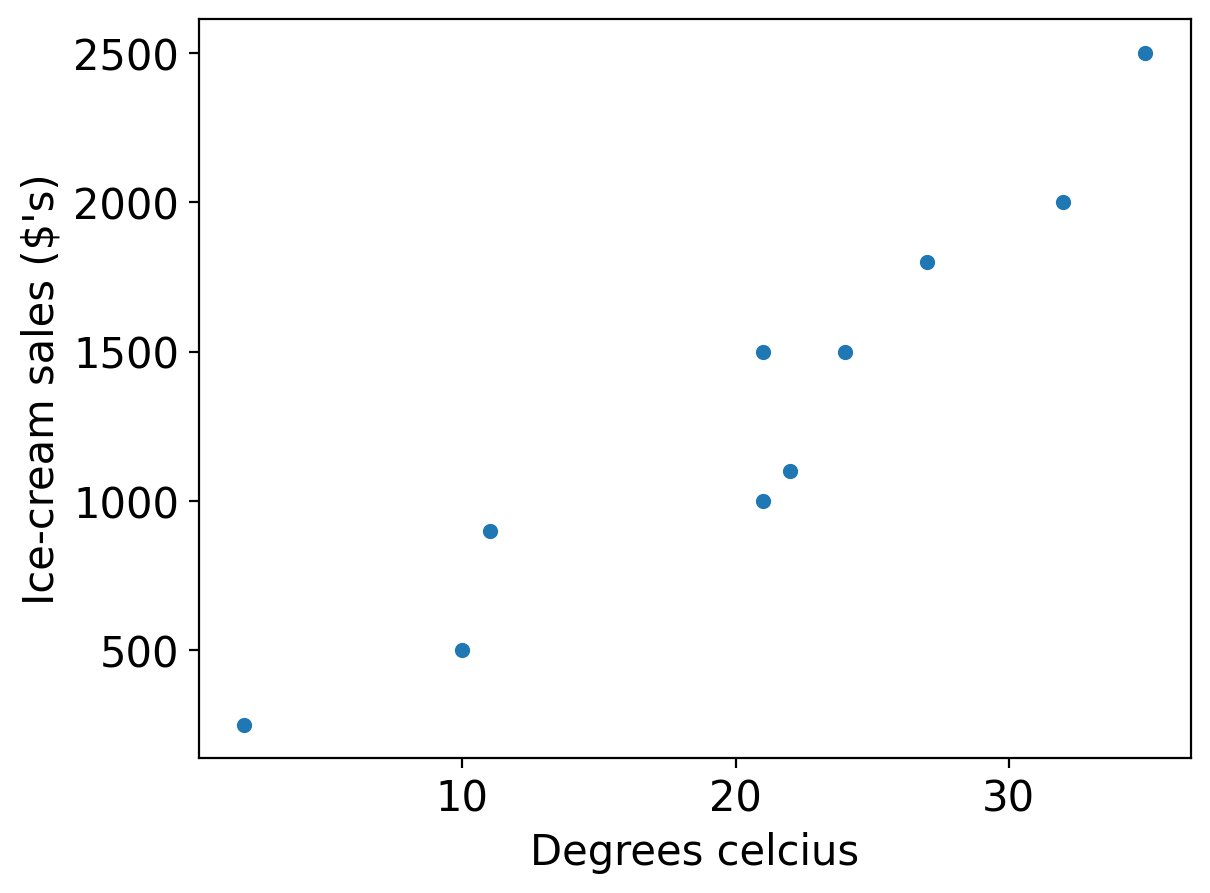

In [3]:
# Example taken from https://intro.quantecon.org/simple_linear_regression.html

import pandas as pd

x = [32, 21, 24, 35, 10, 11, 22, 21, 27, 2]
y = [2000,1000,1500,2500,500,900,1100,1500,1800, 250]
df = pd.DataFrame([x,y]).T
df.columns = ['X', 'Y']

ax = df.plot(
    x='X', 
    y='Y', 
    kind='scatter', 
    ylabel='Ice-cream sales ($\'s)', 
    xlabel='Degrees celcius'
)
plt.show()

We can do a bit of "chi by eye" fitting and find two coefficients, calculate the model $\hat{y}$.
We can also estimate the model error $\hat{e}_i$ at each point:

$$
\hat{e}_i = y_i - \hat{y}_i = y_i - (c_0 + c_1 \cdot x_i)
$$

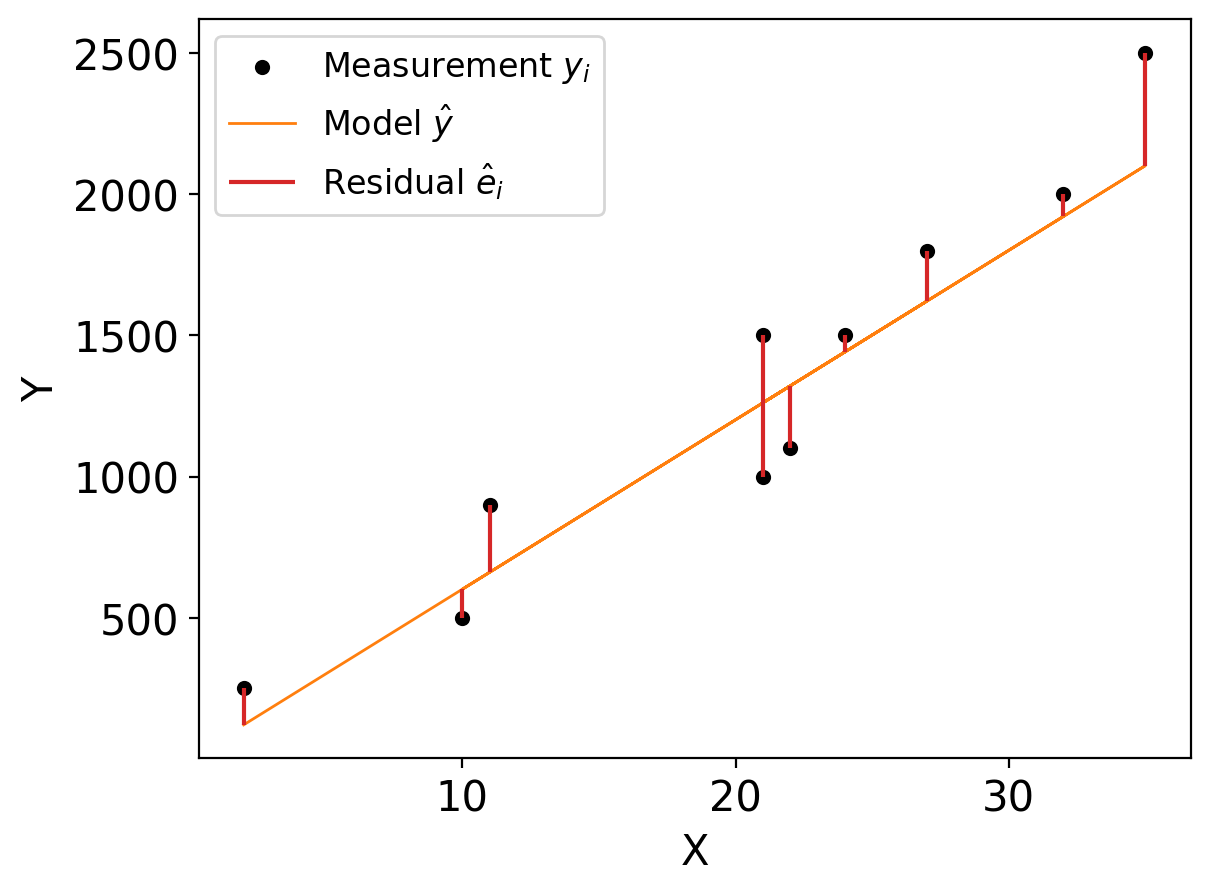

In [4]:
# Define the error function (sum of squared differences)
def model_function(c_0, c_1, x):
    y_model = c_0 + c_1 * x
    return y_model

def error_function(c_0, c_1, x, y):
    y_model = model_function(c_0, c_1, x)
    return np.sum((y_model - y) ** 2)

c_0 = 1
c_1 = 60

df['Y_hat'] = model_function(c_0, c_1, df['X'])
df['error'] = error_function(c_0, c_1, df['X'], df['Y'])

fig, ax = plt.subplots()
ax = df.plot(x='X',y='Y', kind='scatter', ax=ax, c = 'k', label = r'Measurement $y_i$')
ax = df.plot(x='X',y='Y_hat', kind='line', ax=ax, color='C1', lw = 1, label = r'Model $\hat{y}$')
plt.vlines(df['X'], df['Y_hat'], df['Y'], color='C3', label =r'Residual $\hat{e}_i$')
plt.legend()
plt.show()

The Ordinary Least Squares (OLS) method chooses $c_0$ and $c_1$ in such a way that **minimizes** the sum of the squared residuals (SSR):

$$
\min_{c_0,c_1} \sum_{i=1}^N \hat{e}_i^2 = \min_{c_0,c_1} \sum_{i=1}^N (y_i - (c_0 + c_1 \cdot x_i))^2 = \min_{c_0,c_1} E
$$

There are multiple ways how we could solve this.  
One of them could certainly be to select a range of $c_0$ and/or $c_1$ values calculate the error function.  
Let's first do test the behavior of the error function when fixing $c_0$ to 0 and changing $c_1$.  
In a second step, let's optimise over a grid of changing $c_0$ and $c_2$.

### Grid-based searches

In [5]:
c_1_values = np.linspace(25, 100, 10)
errors_c1 = [error_function(0, c_1, df['X'], df['Y']) for c_1 in c_1_values]

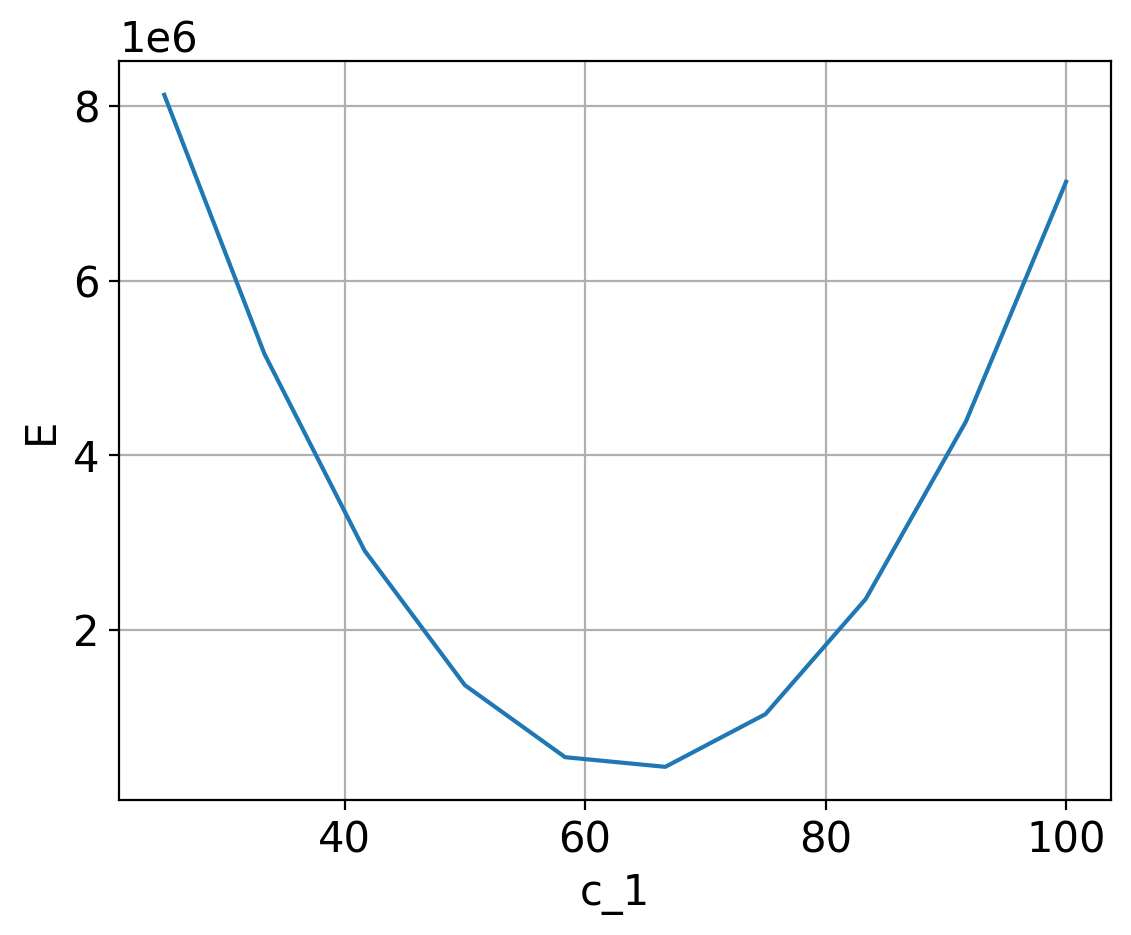

In [6]:
# Plot error function vs c_1 for c_0 = 0
plt.figure()
plt.plot(c_1_values, errors_c1)
plt.xlabel('c_1')
plt.ylabel('E')
plt.grid(True)
plt.show()

In [7]:
# Step 2: Create a grid of c_0 and c_1 and calculate the error

c_0_range = np.linspace(-500, 500, 11) # -500..(100)..500
c_1_range = np.linspace(0, 100, 11) # 0..(10)..100

# create a (10,10) mesh grid from c_0 and c_1
c_0_vals, c_1_vals = np.meshgrid(c_0_range, c_1_range)
print('Shape of c_0_vals and c_1_vals: ',np.shape(c_0_vals), np.shape(c_0_vals))

Shape of c_0_vals and c_1_vals:  (11, 11) (11, 11)


In [8]:
errors_grid = np.zeros((len(c_0_range), len(c_1_range)))
for i, c_0 in enumerate(c_0_range):
    for j, c_1 in enumerate(c_1_range):
        errors_grid[i, j] = error_function(c_0, c_1, df['X'], df['Y'])

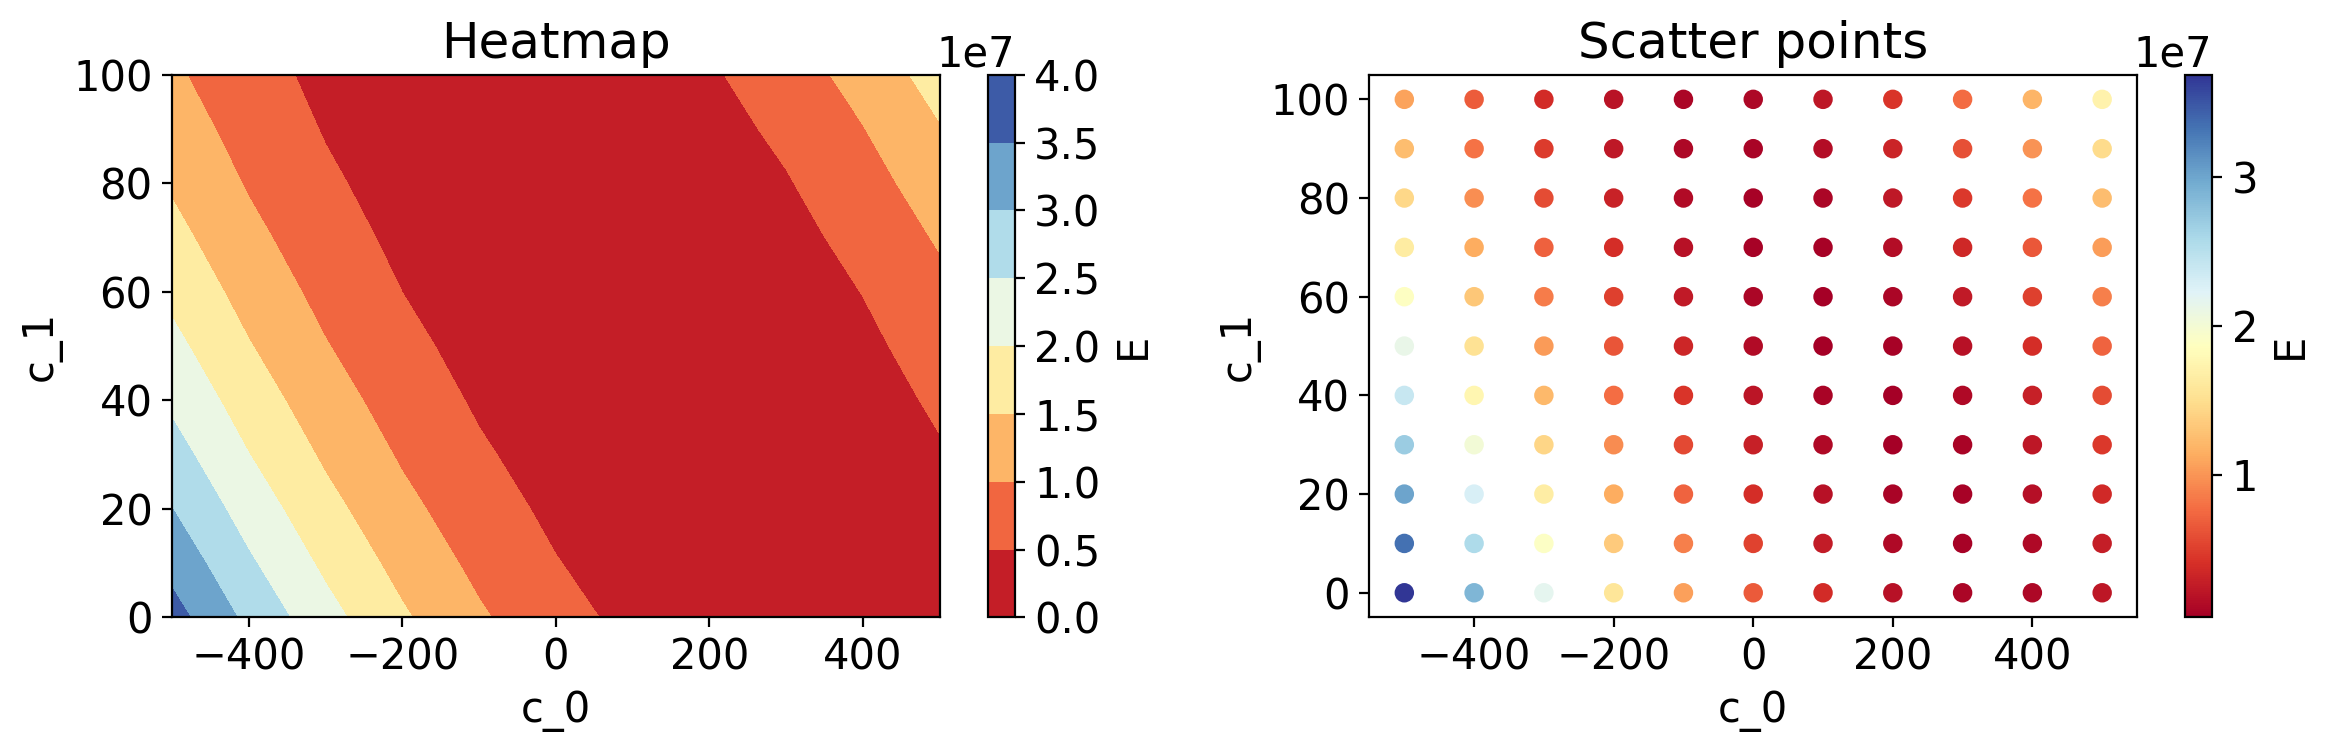

In [9]:
# Plot the error as a heatmap and scatter plot
f, gs = plt.subplots(1,2,figsize=(12,4))

ax = gs[0]
s = ax.contourf(c_0_range, c_1_range, errors_grid, cmap='RdYlBu')
plt.colorbar(s, ax=ax,label='E')
ax.set_xlabel('c_0')
ax.set_ylabel('c_1')
ax.set_title('Heatmap')

ax = gs[1]
s = plt.scatter(c_0_vals, c_1_vals, c = errors_grid, label='Grid Points', cmap='RdYlBu')
plt.colorbar(s, ax=ax,label='E')
ax.set_xlabel('c_0')
ax.set_ylabel('c_1')
ax.set_title('Scatter points')

plt.tight_layout()
plt.show()

Clearly the range that we cover is covering a significant range in error

This is maybe not the best visualisation. Let's plot the logarithmic values of the error function!

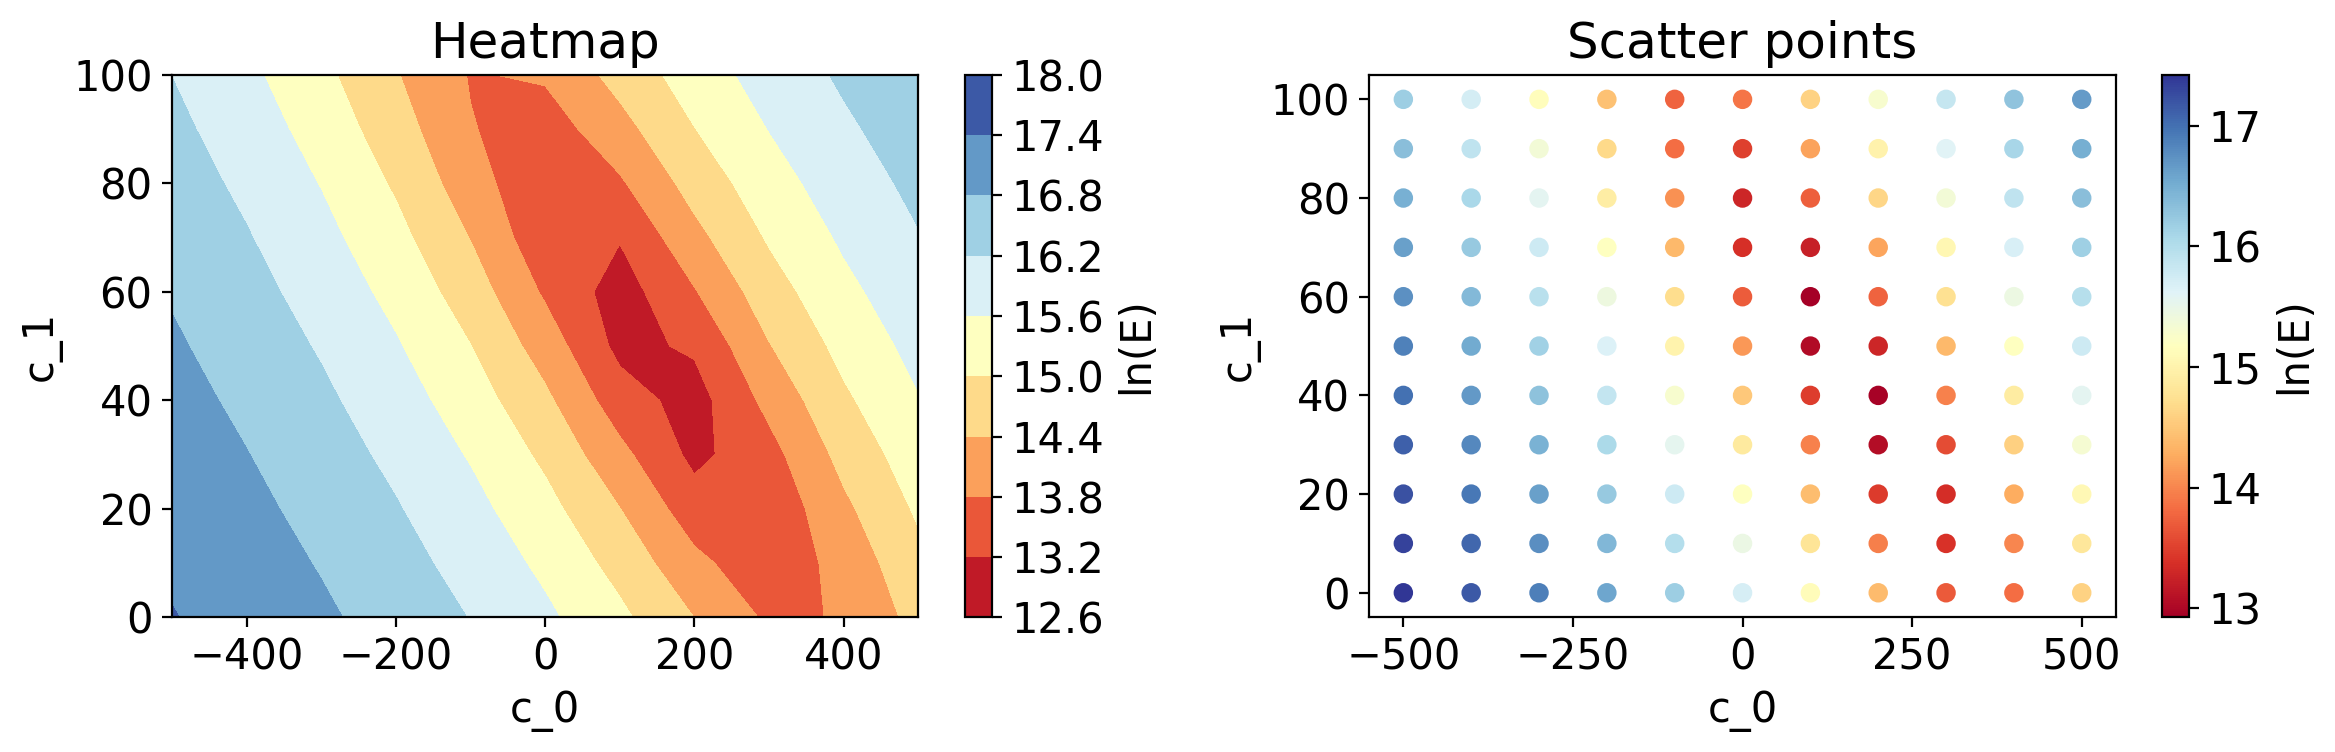

In [10]:
# Plot the ln(error) as a heatmap and scatter
f, gs = plt.subplots(1,2,figsize=(12,4))

ax = gs[0]
s = ax.contourf(c_0_range, c_1_range, np.log(errors_grid), cmap='RdYlBu')
plt.colorbar(s, ax=ax,label='ln(E)')
ax.set_xlabel('c_0')
ax.set_ylabel('c_1')
ax.set_title('Heatmap')

ax = gs[1]
s = plt.scatter(c_0_vals, c_1_vals, c = np.log(errors_grid), label='Grid Points', cmap='RdYlBu')
plt.colorbar(s, ax=ax,label='ln(E)')
ax.set_xlabel('c_0')
ax.set_ylabel('c_1')
ax.set_title('Scatter points')

plt.tight_layout()
plt.show()

This way of estimating optimal parameters is a grid-based search. There are reasons to use it (e.g. if you want to avoid getting stuck in local minima).

But you might want to consider smarter methods, if you can - or if you do not know which range you actually have to cover!

### Minimizing the error function

To find the best values for c_0 and c_1, we just need to find the derivatives (using the chain rule)

$$
0 = \frac{\delta E}{\delta c_0} = \frac{\delta}{\delta c_0} \sum_{i=1}^N (y_i - (c_0 + c_1 * x_i))^2 = \sum_{i=1}^N - 2 (y_i - (c_0 + c_1 * x_i)) \\
0 = \frac{\delta E}{\delta c_1} = \frac{\delta}{\delta c_1} \sum_{i=1}^N (y_i - (c_0 + c_1 * x_i))^2 = \sum_{i=1}^N - 2 x_i \cdot (y_i - (c_0 + c_1 * x_i))
$$

Dividing by -2 yields

$$
0 = \sum_{i=1}^N  (y_i - (c_0 + c_1 * x_i)) = \sum_{i=1}^N y_i - N \cdot c_0 + c_1 \cdot \sum_{i=1}^N x_i \quad \rightarrow \quad c_0 = \frac{1}{N} \sum_{i=1}^N y_i - c_1 \cdot \frac{1}{N} \sum_{i=1}^N x_i = \bar{y_i} - c_1 \cdot \bar{x_i}
$$

We can subsitute this into the partial derivative $\frac{\delta E}{\delta c_1}$ and get

$$
0 = \sum_{i=1}^N (x_i y_i - \bar{y_i} x_i) + c_1 \sum_{i=1}^N (\bar{x_i} x_i - x_i^2) \quad \rightarrow \quad c_1 = \frac{\sum_{i=1}^N (x_i y_i - \bar{y_i} x_i)}{\sum_{i=1}^N (x_i^2 - \bar{x_i} x_i)}
$$


In [11]:
# Copy the original data
df = df[['X','Y']].copy()

# Calculate the sample means
x_bar = df['X'].mean()
y_bar = df['Y'].mean()

# Compute the Sums
df['num'] = df['X'] * df['Y'] - y_bar * df['X']
df['den'] = df['X']**2 - x_bar * df['X']

# Calculate c_1 and then c_0 using the equations above
c_1 = df['num'].sum() / df['den'].sum()
c_0 = y_bar - c_1 * x_bar

print('c_0:', np.round(c_0,2), 'c_1:', np.round(c_1, 2))

c_0: -14.72 c_1: 64.38


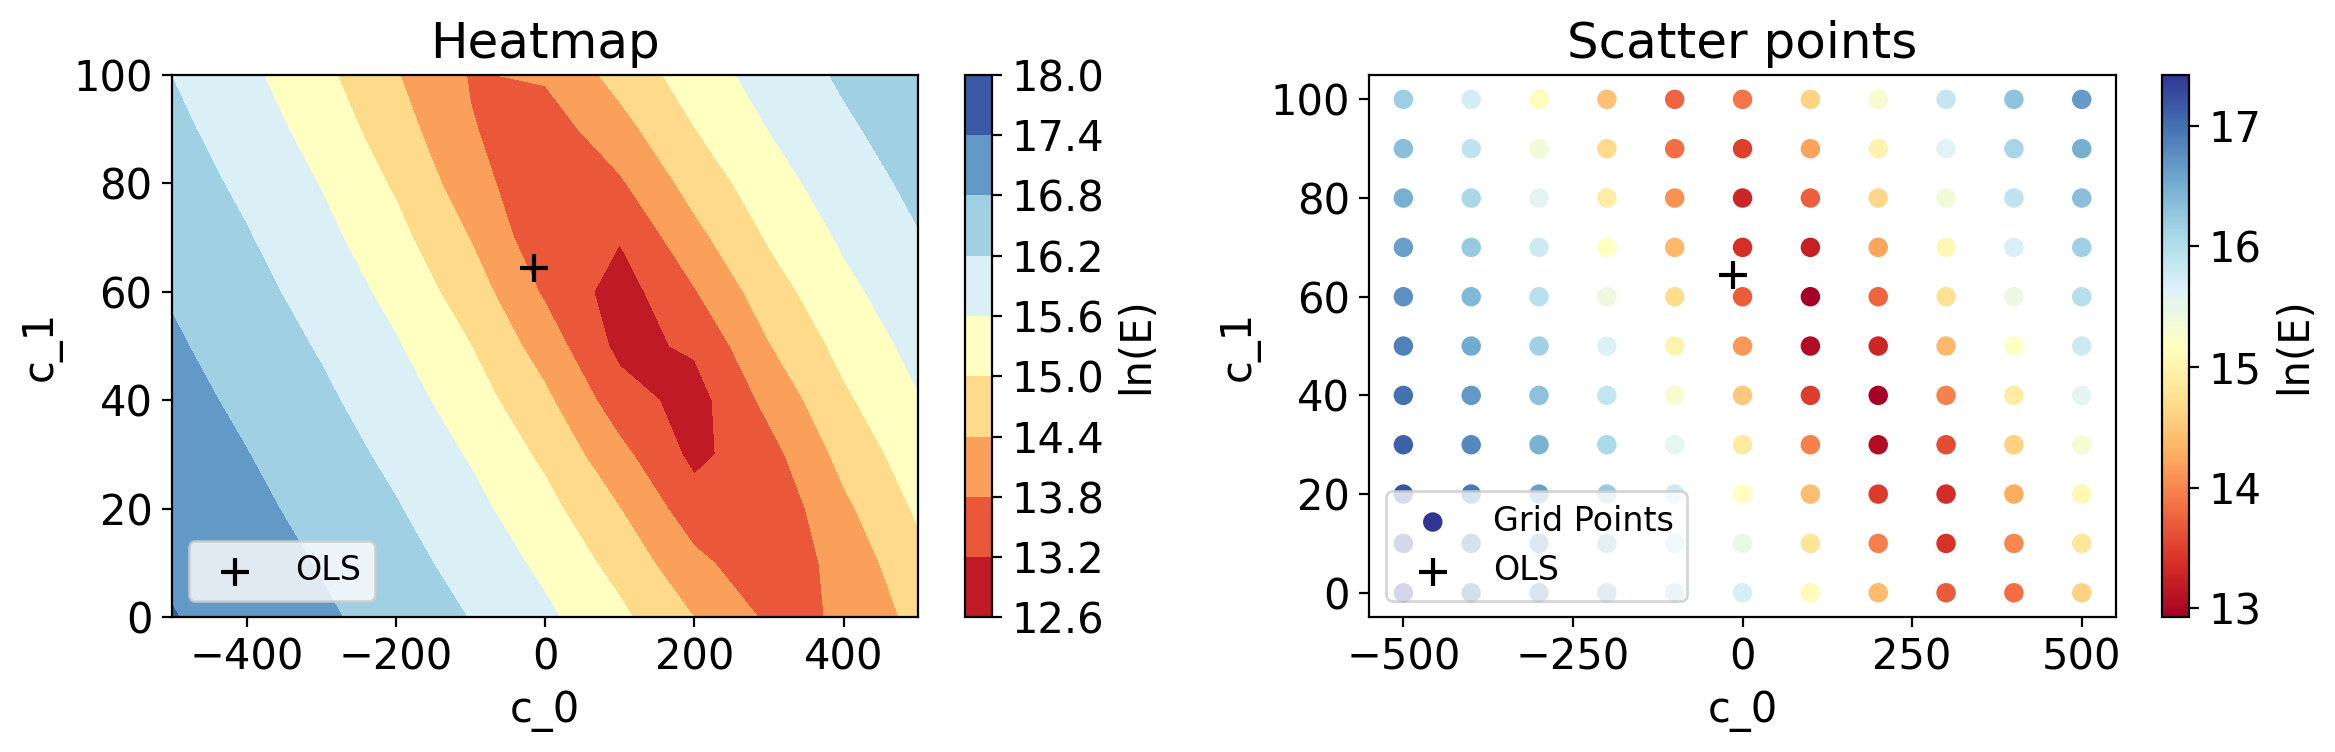

In [12]:
# Plot the error as a heatmap  
f, gs = plt.subplots(1,2,figsize=(12,4))

ax = gs[0]
s = ax.contourf(c_0_range, c_1_range, np.log(errors_grid), cmap='RdYlBu')
plt.colorbar(s, ax=ax,label='ln(E)')
ax.set_xlabel('c_0')
ax.set_ylabel('c_1')
ax.set_title('Heatmap')
ax.scatter([c_0],[c_1], c = 'k', label = 'OLS', marker='+', s=100)
ax.legend(loc='lower left')

ax = gs[1]
s = plt.scatter(c_0_vals, c_1_vals, c = np.log(errors_grid), cmap='RdYlBu', label='Grid Points')
plt.colorbar(s, ax=ax,label='ln(E)')
ax.set_xlabel('c_0')
ax.set_ylabel('c_1')
ax.set_title('Scatter points')

ax.scatter([c_0],[c_1], c = 'k', label = 'OLS', marker='+', s=100)
ax.legend(loc='lower left')

plt.tight_layout()
plt.show()

## Fitting a model to data

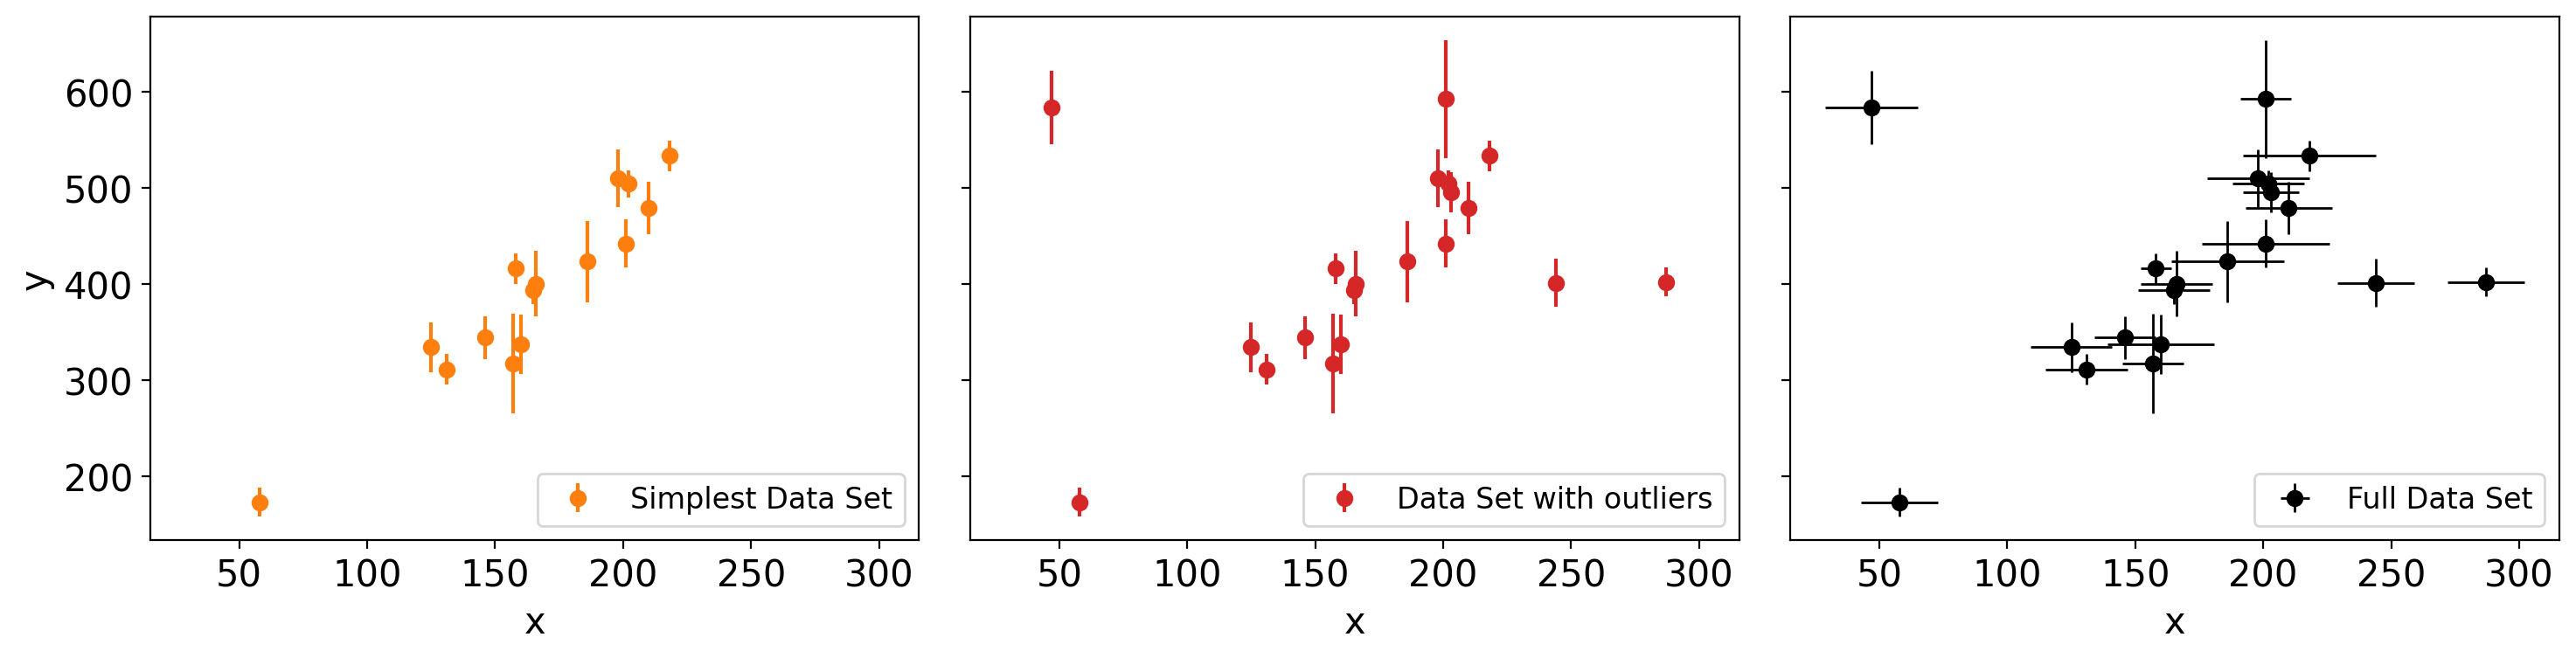

In [13]:
# Table 1: The Data from Hogg, Bovy, and Lang (2010): https://arxiv.org/abs/1008.4686 

x_data_full   = np.array([201, 244, 47, 287, 203, 58, 210, 202, 198, 158, 
                   165, 201, 157, 131, 166, 160, 186, 125, 218, 146])
y_data_full   = np.array([592, 401, 583, 402, 495, 173, 479, 504, 510, 416, 
                   393, 442, 317, 311, 400, 337, 423, 334, 533, 344])
x_sigma_full = np.array([10, 15, 18, 15, 11, 15, 17, 14, 20, 6, 
                     14, 25, 12, 16, 14, 21, 22, 16, 26, 12])
y_sigma_full = np.array([61, 25, 38, 15, 21, 15, 27, 14, 30, 16, 
                     14, 25, 52, 16, 34, 31, 42, 26, 16, 22])

x_data_simple = x_data_full[5:]
y_data_simple = y_data_full[5:]
y_sigma_simple = y_sigma_full[5:]

f, gs = plt.subplots(1,3,sharex=True,sharey=True,figsize=(15,4))

ax = gs[0]
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.errorbar(x_data_simple, y_data_simple, yerr=y_sigma_simple, fmt='o', label='Simplest Data Set', c = 'C1')
ax.legend(fontsize=12, loc='lower right')

ax = gs[1]
ax.set_xlabel('x')
ax.errorbar(x_data_full, y_data_full, yerr=y_sigma_full, fmt='o', label='Data Set with outliers', c = 'C3')
ax.legend(fontsize=12, loc='lower right')

ax = gs[2]
ax.set_xlabel('x')
ax.errorbar(x_data_full, y_data_full, xerr = x_sigma_full, yerr=y_sigma_full, fmt='o', lw=1, label='Full Data Set', c = 'k')
ax.legend(fontsize=12, loc='lower right')

plt.tight_layout()
plt.show()

### Complexity 0: The simplest case

Let's assume a linear model 

$$y = mx + b$$

- No uncertainties for $x$
- No uncertainties for $y$
- No outliers

In [14]:
import numpy as np

# Step 1: Define the data
x = x_data_simple
y = y_data_simple

# Step 2: Create the design matrix X
# We add a column of ones for the bias term (c_0)
X = np.column_stack((np.ones(x.shape[0]), x))

# Step 3: Compute the normal equation components
# X^T X and X^T y
XT_X = np.dot(X.T, X)  # X.T is the transpose of X
XT_y = np.dot(X.T, y)

# Step 4: Compute the covariance matrix of the coefficients
cov_matrix = np.linalg.inv(XT_X)

# Step 5: Solve for the coefficients (c_0, c_1)
coefficients = cov_matrix.dot(XT_y)

# Step 5: Output the coefficients
c_0, c_1 = coefficients

# Step 6: Exctract coefficient sigma
diagonal_entries_sigma = np.sqrt(np.diag(cov_matrix))
c_0_sigma = diagonal_entries_sigma[0]
c_1_sigma = diagonal_entries_sigma[1]

# Step 7: Use the coefficients to predict y values
y_pred = X.dot(coefficients)

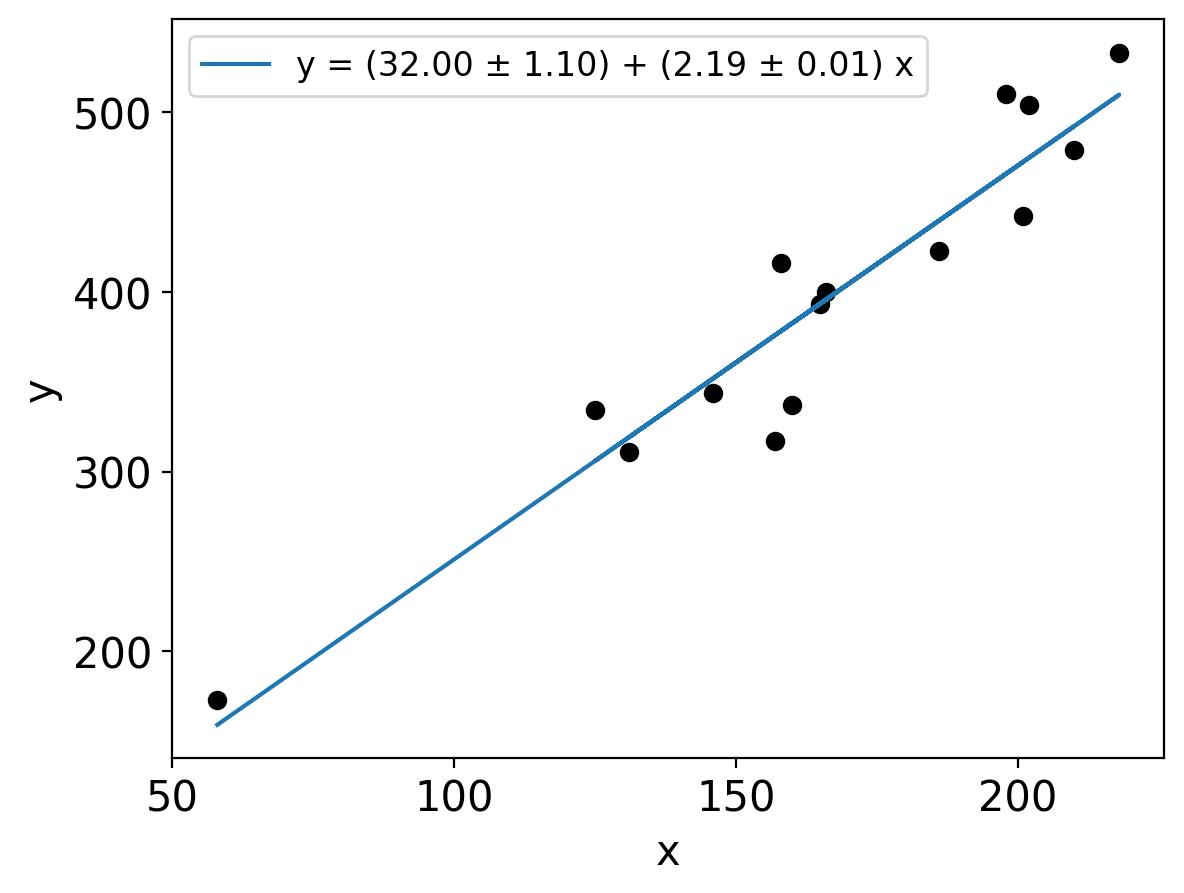

In [15]:
# Plot 
f, ax = plt.subplots()
ax.scatter(x, y, c = 'k')
ax.plot(x, y_pred, label = f"y = ({c_0:.2f} ± {c_0_sigma:.2f}) + ({c_1:.2f} ± {c_1_sigma:.2f}) x")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.show()
plt.close()

### Complexity 1: uncertainty in y

- No uncertainties for $x$
- **Gaussian uncertainties for $y$**
- No outliers

In [16]:
import numpy as np

# Step 1: Define the data and uncertainties
x = x_data_simple
y = y_data_simple
y_sigma = y_sigma_simple

# Step 2: Create the design matrix X
# We add a column of ones for the bias term (c_0)
X = np.column_stack((np.ones(x.shape[0]), x))

# Step 3: Create the weights matrix W
W = np.diag(1 / y_sigma**2)  # Diagonal matrix of 1/y_sigma^2

# Step 4: Compute the weighted normal equation components
# X^T W X and X^T W y
XT_W_X = np.dot(X.T, np.dot(W, X))
XT_W_y = np.dot(X.T, np.dot(W, y))

# Step 5: Compute the covariance matrix of the coefficients
cov_matrix = np.linalg.inv(XT_W_X)

# Step 5: Solve for the coefficients (c_0, c_1)
coefficients = cov_matrix.dot(XT_W_y)

# Step 6: Output the coefficients
c_0, c_1 = coefficients

# Step 7: Exctract coefficient sigma
diagonal_entries_sigma = np.sqrt(np.diag(cov_matrix))
c_0_sigma = diagonal_entries_sigma[0]
c_1_sigma = diagonal_entries_sigma[1]

# Step 8: Use the coefficients to predict y values
y_pred = X.dot(coefficients)

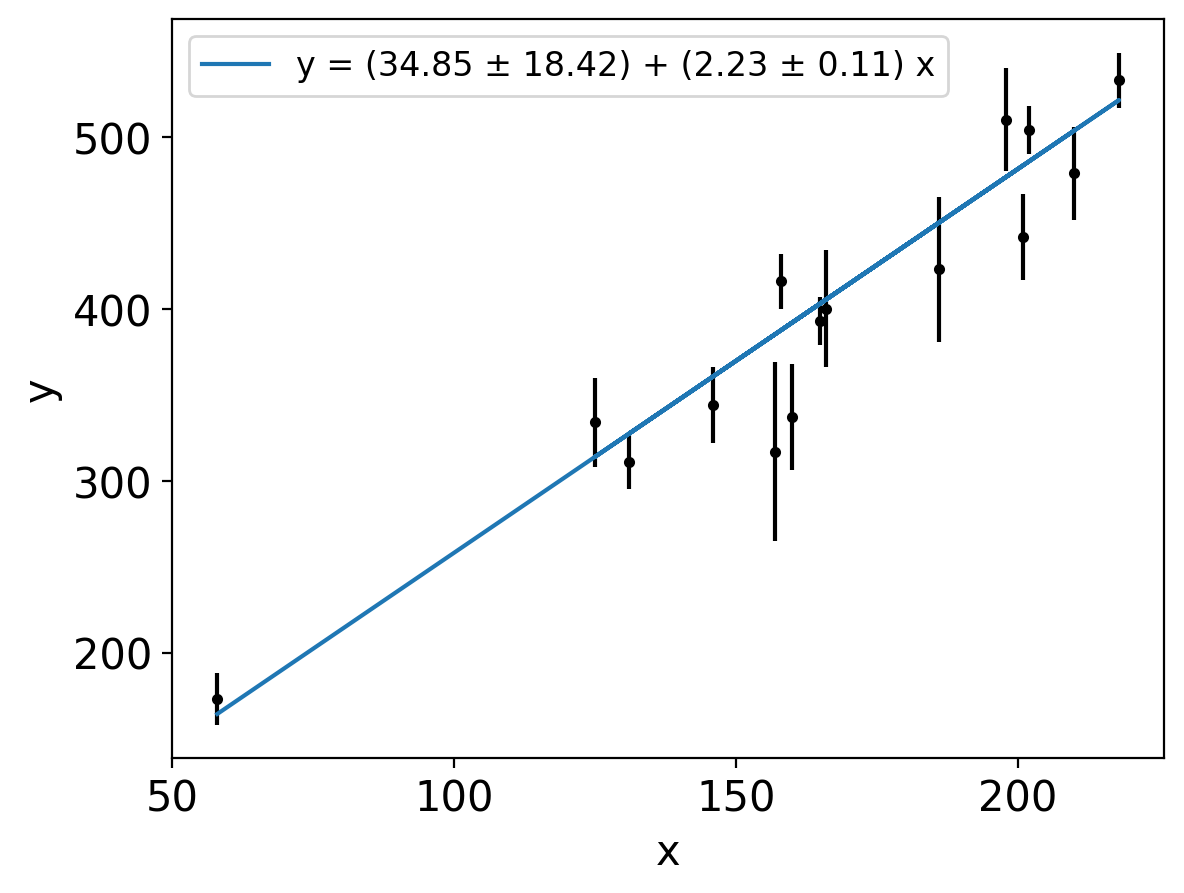

In [17]:
# Plot 
f, ax = plt.subplots()
ax.errorbar(x, y, yerr = y_sigma, c = 'k', fmt = '.')
ax.plot(x, y_pred, label = f"y = ({c_0:.2f} ± {c_0_sigma:.2f}) + ({c_1:.2f} ± {c_1_sigma:.2f}) x")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.show()
plt.close()

### Complexity 2: Outliers

In [18]:
import numpy as np

# Step 1: Define the data and uncertainties
x = x_data_full
y = y_data_full
y_sigma = y_sigma_full

# Step 2: Create the design matrix X
# We add a column of ones for the bias term (c_0)
X = np.column_stack((np.ones(x.shape[0]), x))

# Step 3: Create the weights matrix W
W = np.diag(1 / y_sigma**2)  # Diagonal matrix of 1/y_sigma^2

# Step 4: Compute the weighted normal equation components
# X^T W X and X^T W y
XT_W_X = np.dot(X.T, np.dot(W, X))
XT_W_y = np.dot(X.T, np.dot(W, y))

# Step 5: Compute the covariance matrix of the coefficients
cov_matrix = np.linalg.inv(XT_W_X)

# Step 5: Solve for the coefficients (c_0, c_1)
coefficients_out = cov_matrix.dot(XT_W_y)

# Step 6: Output the coefficients
c_0_out, c_1_out = coefficients_out

# Step 7: Exctract coefficient sigma
diagonal_entries_sigma = np.sqrt(np.diag(cov_matrix))
c_0_sigma_out = diagonal_entries_sigma[0]
c_1_sigma_out = diagonal_entries_sigma[1]

# Step 8: Use the coefficients to predict y values
y_pred_out = X.dot(coefficients_out)

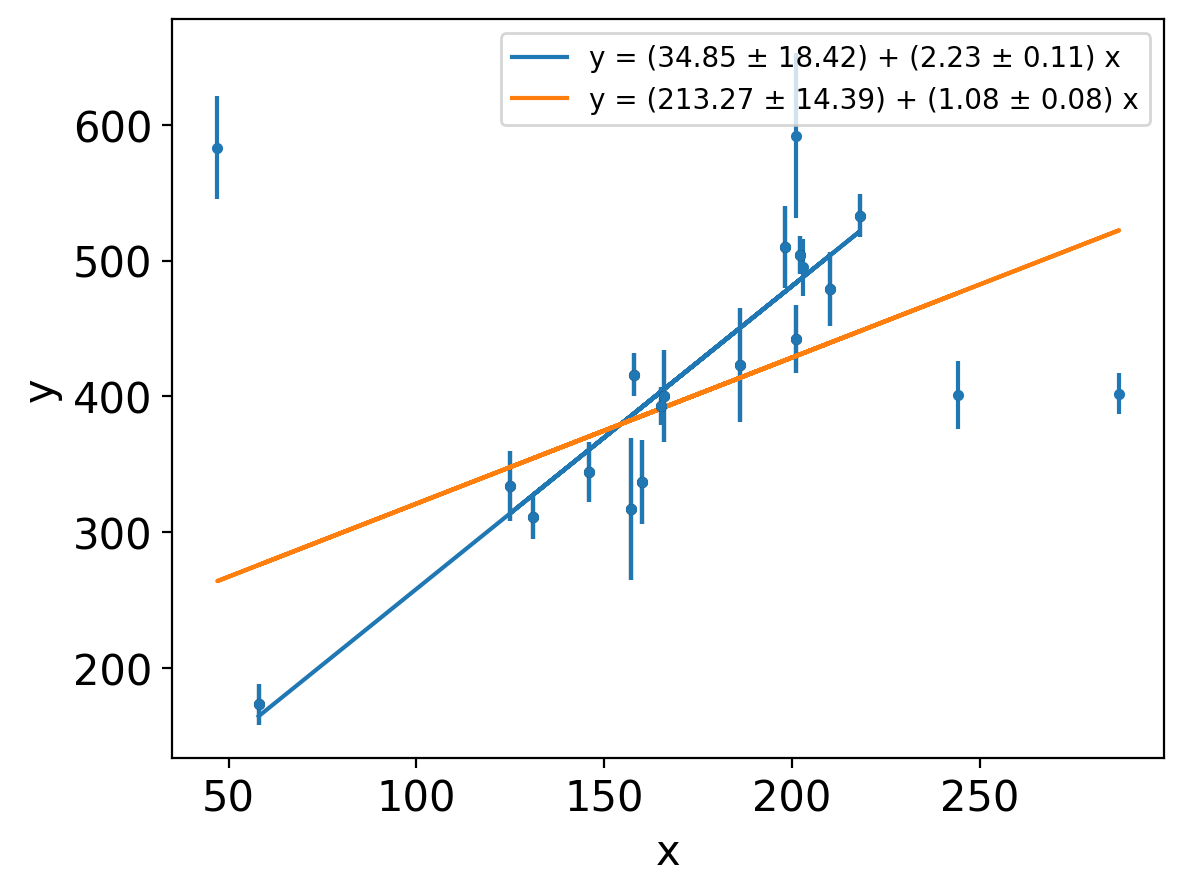

In [19]:
# Plot 
f, ax = plt.subplots()
ax.errorbar(x_data_simple, y_data_simple, yerr = y_sigma_simple, c = 'k', fmt = '.')
ax.errorbar(x, y, yerr = y_sigma, c = 'C0', fmt = '.')
ax.plot(x_data_simple, y_pred, label = f"y = ({c_0:.2f} ± {c_0_sigma:.2f}) + ({c_1:.2f} ± {c_1_sigma:.2f}) x")
ax.plot(x, y_pred_out, label = f"y = ({c_0_out:.2f} ± {c_0_sigma_out:.2f}) + ({c_1_out:.2f} ± {c_1_sigma_out:.2f}) x")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(fontsize=10)
plt.show()
plt.close()

### Complexity 3+: A quadratic function with a slightly different naming convention

Quadratic term (q): 0.0023 ± 0.0021
Slope (m): 1.60 ± 0.58
Intercept (b): 72.58 ± 38.96


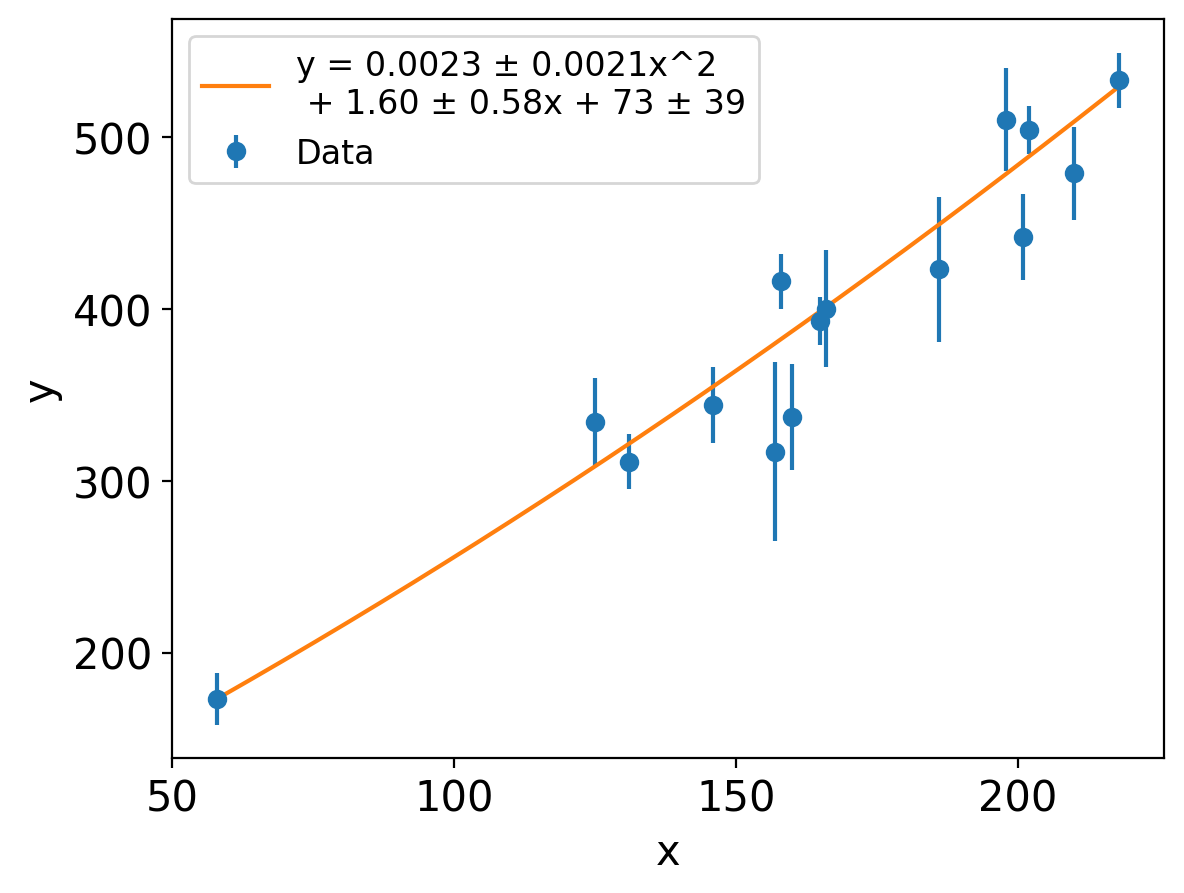

In [20]:
# Quadratic function

# Data points 5 through 20 from Table 1
x_data = x_data_simple
y_data = y_data_simple
y_errors = y_sigma_simple

# Quadratic fit (add x^2 column to the design matrix A)
A_quad_ex3 = np.vstack([x_data**2, x_data, np.ones(len(x_data))]).T
Y_ex3 = y_data
C_ex3 = np.diag(y_errors**2)

# Solve the least-squares problem using the weighted linear least-squares formula
A_T_C_inv_ex3 = np.dot(A_quad_ex3.T, np.linalg.inv(C_ex3))
cov_matrix_ex3 = np.linalg.inv(np.dot(A_T_C_inv_ex3, A_quad_ex3))
best_fit_params_ex3 = np.dot(cov_matrix_ex3, np.dot(A_T_C_inv_ex3, Y_ex3))

# Extract quadratic (q), slope (m), and intercept (b)
q_ex3, m_ex3, b_ex3 = best_fit_params_ex3
q_uncertainty_ex3 = np.sqrt(cov_matrix_ex3[0, 0])
slope_uncertainty_ex3 = np.sqrt(cov_matrix_ex3[1, 1])
intercept_uncertainty_ex3 = np.sqrt(cov_matrix_ex3[2, 2])

# Print the result
print(f"Quadratic term (q): {q_ex3:.4f} ± {q_uncertainty_ex3:.4f}")
print(f"Slope (m): {m_ex3:.2f} ± {slope_uncertainty_ex3:.2f}")
print(f"Intercept (b): {b_ex3:.2f} ± {intercept_uncertainty_ex3:.2f}")

# Generate a smooth set of x values for plotting the quadratic curve
x_smooth = np.linspace(min(x_data), max(x_data), 500)

# Plot the data and the quadratic fit
plt.errorbar(x_data, y_data, yerr=y_errors, fmt='o', label='Data')
plt.plot(x_smooth, q_ex3 * x_smooth**2 + m_ex3 * x_smooth + b_ex3, label=f'y = {q_ex3:.4f} ± {q_uncertainty_ex3:.4f}x^2 \n + {m_ex3:.2f} ± {slope_uncertainty_ex3:.2f}x + {b_ex3:.0f} ± {intercept_uncertainty_ex3:.0f}')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(fontsize=12)
plt.show()

## When should I use what python fitting function?

### numpy.polyfit

Best for: Linear and polynomial fits (up to quadratic and higher).

In [21]:
import numpy as np

# Linear fit
linear_fit = np.polyfit(x_data, y_data, 1)  # 1 for linear
m, b = linear_fit  # slope and intercept

# Quadratic fit
quadratic_fit = np.polyfit(x_data, y_data, 2)  # 2 for quadratic
q, m, b = quadratic_fit  # quadratic, slope, and intercept

### scipy.optimize.curve_fit

Best for: Non-linear curve fitting, customizable models.

Linear Fit: y = 2.23x + 34.85
Linear Fit uncertainties: m = 0.11, b = 18.42
Quadratic Fit: y = 0.0023x^2 + 1.60x + 72.58
Quadratic Fit uncertainties: q = 0.0021, m = 0.58, b = 38.96


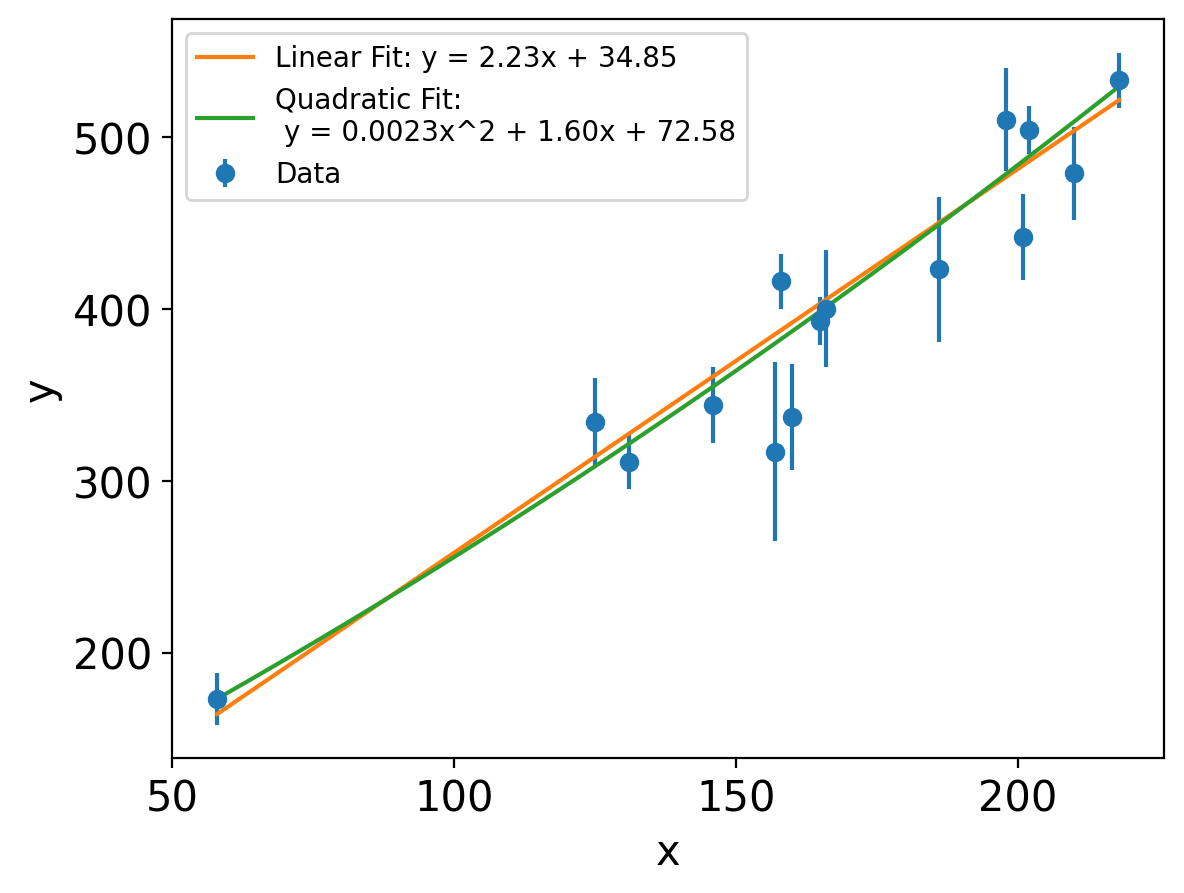

In [22]:
from scipy.optimize import curve_fit

# Define linear model
def linear_model(x, m, b):
    # print(m, b)
    return m * x + b

# Define quadratic model
def quadratic_model(x, q, m, b):
    return q * x**2 + m * x + b

# curve_fit will provide you with optimal parameters and a parameter covariance matrix.
# To extract the standard deviation of the fitted parameters, you can use np.sqrt(np.diag())
# to extract the square root of the diagonal entries

# Linear fit with uncertainties
popt_linear, pcov_linear = curve_fit(linear_model, x_data, y_data, sigma=y_errors, absolute_sigma=True)
m_linear, b_linear = popt_linear
perr_linear = np.sqrt(np.diag(pcov_linear))

# Quadratic fit with uncertainties
popt_quad, pcov_quad = curve_fit(quadratic_model, x_data, y_data, sigma=y_errors, absolute_sigma=True)
q_quad, m_quad, b_quad = popt_quad
perr_quad = np.sqrt(np.diag(pcov_quad))

# Print results with uncertainties
print(f"Linear Fit: y = {m_linear:.2f}x + {b_linear:.2f}")
print(f"Linear Fit uncertainties: m = {perr_linear[0]:.2f}, b = {perr_linear[1]:.2f}")
print(f"Quadratic Fit: y = {q_quad:.4f}x^2 + {m_quad:.2f}x + {b_quad:.2f}")
print(f"Quadratic Fit uncertainties: q = {perr_quad[0]:.4f}, m = {perr_quad[1]:.2f}, b = {perr_quad[2]:.2f}")

# Plot results
x_smooth = np.linspace(min(x_data), max(x_data), 500)
plt.errorbar(x_data, y_data, yerr=y_errors, fmt='o', label='Data')

# Plot linear and quadratic fits
plt.plot(x_smooth, linear_model(x_smooth, *popt_linear), label=f'Linear Fit: y = {m_linear:.2f}x + {b_linear:.2f}')
plt.plot(x_smooth, quadratic_model(x_smooth, *popt_quad), label=f'Quadratic Fit: \n y = {q_quad:.4f}x^2 + {m_quad:.2f}x + {b_quad:.2f}')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(fontsize=10)
plt.show()

### statsmodels.api as sm

Best for: Regression analysis with robust statistical output, linear and polynomial regression.

In [23]:
import statsmodels.api as sm

# Linear model
x_with_intercept = sm.add_constant(x_data)  # Adds the intercept term
linear_model = sm.OLS(y_data, x_with_intercept).fit()

# Print linear model summary (with statistical info)
print(linear_model.summary())

# Quadratic model
x_data_quad = np.column_stack((x_data**2, x_data))
x_data_quad_with_intercept = sm.add_constant(x_data_quad)
quadratic_model = sm.OLS(y_data, x_data_quad_with_intercept).fit()

# Print quadratic model summary
print(quadratic_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     115.3
Date:                Tue, 23 Sep 2025   Prob (F-statistic):           7.84e-08
Time:                        15:41:45   Log-Likelihood:                -71.931
No. Observations:                  15   AIC:                             147.9
Df Residuals:                      13   BIC:                             149.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.0040     34.715      0.922      0.3

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.957
Model:                            WLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     286.5
Date:                Tue, 23 Sep 2025   Prob (F-statistic):           3.08e-10
Time:                        15:41:45   Log-Likelihood:                -70.109
No. Observations:                  15   AIC:                             144.2
Df Residuals:                      13   BIC:                             145.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.8459     22.026      1.582      0.1

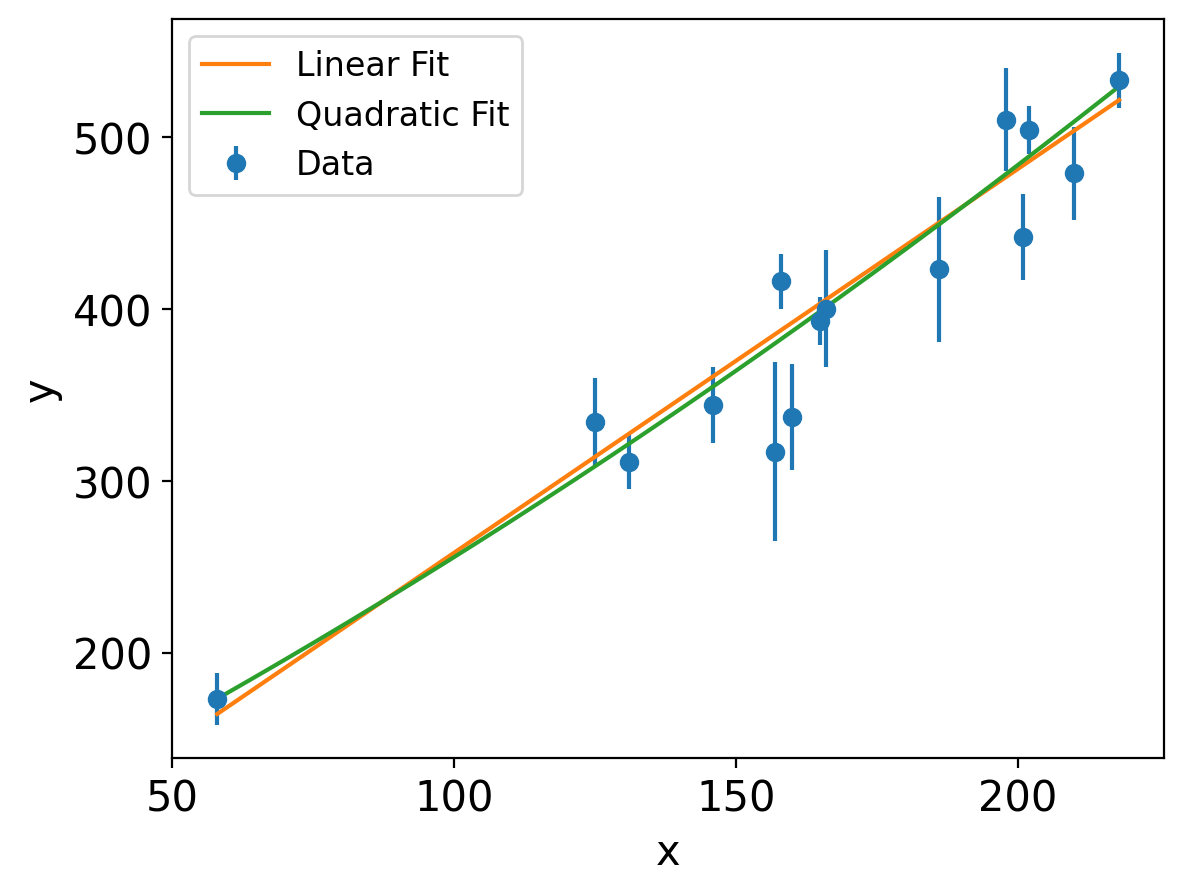

In [24]:
# And with uncertainties:

# Weights (1/variance)
weights = 1 / y_errors**2

# Linear fit with weights
x_data_linear = sm.add_constant(x_data)
model_linear = sm.WLS(y_data, x_data_linear, weights=weights)
result_linear = model_linear.fit()

# Quadratic fit with weights
x_data_quad = np.column_stack((x_data, x_data**2))
x_data_quad = sm.add_constant(x_data_quad)
model_quad = sm.WLS(y_data, x_data_quad, weights=weights)
result_quad = model_quad.fit()

# Print summaries
print(result_linear.summary())
print(result_quad.summary())

# Plot data
x_smooth = np.linspace(min(x_data), max(x_data), 500)
plt.errorbar(x_data, y_data, yerr=y_errors, fmt='o', label='Data')

# Plot linear fit
linear_fit = result_linear.params[0] + result_linear.params[1] * x_smooth
plt.plot(x_smooth, linear_fit, label='Linear Fit')

# Plot quadratic fit
quad_fit = result_quad.params[0] + result_quad.params[1] * x_smooth + result_quad.params[2] * x_smooth**2
plt.plot(x_smooth, quad_fit, label='Quadratic Fit')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## What if I also have uncertainties on my x-data?

### Methodology

#### Total Uncertainty ($\sigma_{\text{total}}$) in $y_i$

The **total uncertainty** in $y_i$, denoted as $\sigma_{\text{total}, i}$, arises from two sources:
1. **Measurement error in $y_i$**, given by $\sigma_{y_i}$.
2. **Measurement error in $x_i$**, which propagates through the model and contributes to the uncertainty in $y_i$.

To compute the total uncertainty, we must propagate the uncertainty in $x_i$ through the quadratic model $y = q x^2 + m x + b$.

#### Propagating the Uncertainty in $x_i$

To propagate the uncertainty in $x_i$ to the predicted value of $y_i$, we use the following general rule for **error propagation**:

If $y$ depends on $x$ through some function $y = f(x)$, the uncertainty in $y$ due to the uncertainty in $x$ is given by:
$$
\sigma_{y, \text{prop}}^2 = \left( \frac{\partial f}{\partial x} \right)^2 \sigma_x^2
$$
Where:
- $\frac{\partial f}{\partial x}$ is the derivative of the function $f(x)$ with respect to $x$,
- $\sigma_x$ is the uncertainty in $x$,
- $\sigma_{y, \text{prop}}$ is the propagated uncertainty in $y$.

Our model is:
$$
y = q x^2 + m x + b
$$
The derivative of $y$ with respect to $x$ is:
$$
\frac{\partial y}{\partial x} = 2 q x + m
$$

Therefore, the uncertainty in $y_i$ due to the uncertainty in $x_i$ is:
$$
\sigma_{y, \text{prop}, i}^2 = \left( 2 q x_i + m \right)^2 \sigma_{x_i}^2
$$
Where:
- $\sigma_{x_i}$ is the uncertainty in the measurement of $x_i$,
- $2 q x_i + m$ is the rate of change of $y$ with respect to $x$.

#### Total Uncertainty in $y_i$

The total uncertainty in $y_i$, denoted as $\sigma_{\text{total}, i}^2$, combines the measurement uncertainty in $y_i$ and the propagated uncertainty from $x_i$. These uncertainties are independent, so we sum them in quadrature (sum of squares):

$$
\sigma_{\text{total}, i}^2 = \sigma_{y_i}^2 + \left( 2 q x_i + m \right)^2 \sigma_{x_i}^2
$$

This is the total variance for each data point $i$, which incorporates both the uncertainty in $y$ and the uncertainty in $x$.

#### Likelihood Function

When fitting a model to data using a Gaussian likelihood, the likelihood function typically assumes that the residuals (differences between the observed and predicted values) are Gaussian-distributed. For a given data point $i$, the likelihood contribution is:

$$
\mathcal{L}_i = \frac{1}{\sqrt{2 \pi \sigma_{\text{total}, i}^2}} \exp\left( -\frac{(y_i - y_{\text{model}, i})^2}{2 \sigma_{\text{total}, i}^2} \right)
$$
Where:
- $y_i$ is the observed $y$-value for data point $i$,
- $y_{\text{model}, i}$ is the predicted $y$-value from the quadratic model for data point $i$,
- $\sigma_{\text{total}, i}^2$ is the total variance, including both $\sigma_{y_i}^2$ and the propagated uncertainty from $x_i$.

#### Log-Likelihood

In practice, we typically work with the **log-likelihood** (which simplifies the math by turning products of likelihoods into sums):

$$
\log \mathcal{L} = -\frac{1}{2} \sum_i \left[ \frac{(y_i - y_{\text{model}, i})^2}{\sigma_{\text{total}, i}^2} + \log \left( 2 \pi \sigma_{\text{total}, i}^2 \right) \right]
$$

Where:
- $y_{\text{model}, i} = q x_i^2 + m x_i + b$ is the predicted $y$-value from the quadratic model,
- $\sigma_{\text{total}, i}^2 = \sigma_{y_i}^2 + \left( 2 q x_i + m \right)^2 \sigma_{x_i}^2$ is the total variance for data point $i$.


**And in practice?**

### Maximum Likelihood Estimation (MLE)

To find the best-fit parameters \(q\), \(m\), and \(b\), we can **maximize the log-likelihood** using an optimization routine like `scipy.optimize.minimize`. We will minimize the **negative log-likelihood** (since minimizing a negative function is equivalent to maximizing the positive function).

In [25]:
from scipy.optimize import minimize

# Data (replace with your actual data)
x_data = np.array([203, 58, 210, 202, 198, 158, 165, 201, 157, 131, 166, 160, 186, 125, 218, 146])
y_data = np.array([495, 173, 479, 504, 510, 416, 393, 442, 317, 311, 400, 337, 423, 334, 533, 344])
x_errors = np.array([9, 4, 11, 7, 5, 9, 4, 4, 11, 7, 5, 5, 9, 8, 6, 5])
y_errors = np.array([21, 15, 27, 14, 30, 16, 14, 25, 52, 16, 34, 31, 42, 26, 16, 22])

# Quadratic model
def quadratic_model(params, x):
    q, m, b = params
    return q * x**2 + m * x + b

# Total uncertainty including both y-errors and propagated x-errors
def total_uncertainty(params, x, xerr, yerr):
    q, m, b = params
    return np.sqrt(yerr**2 + (2 * q * x + m)**2 * xerr**2)

# Negative log-likelihood function
def neg_log_likelihood(params, x, y, xerr, yerr):
    model = quadratic_model(params, x)
    sigma_total = total_uncertainty(params, x, xerr, yerr)
    log_likelihood = -0.5 * np.sum(((y - model) / sigma_total)**2 + np.log(2 * np.pi * sigma_total**2))
    return -log_likelihood  # We return the negative log-likelihood to minimize it

# Initial guess for the parameters (q, m, b)
initial_guess = [0.001, 1, 100]

# Perform the optimization (MLE)
result = minimize(neg_log_likelihood, initial_guess, args=(x_data, y_data, x_errors, y_errors))

# Extract the best-fit parameters
best_q, best_m, best_b = result.x

# Estimate the uncertainties: The square root of the diagonal of the covariance matrix
cov_matrix = result.hess_inv  # This is the estimated covariance matrix
uncertainties = np.sqrt(np.diag(cov_matrix))

# Extract the uncertainties
q_uncertainty, m_uncertainty, b_uncertainty = uncertainties

# Print the results
print(f"Best-fit parameters from MLE:")
print("q: ",round_to_significant_digits(best_q, q_uncertainty))
print("m: ",round_to_significant_digits(best_m, m_uncertainty))
print("b: ",round_to_significant_digits(best_b, b_uncertainty))

Best-fit parameters from MLE:
q:  (0.0025, 0.0025)
m:  (1.51, 0.69)
b:  (78, 44)


### scipy.odr: Orthogonal Distance Regression

ODR Fit: y = 0.0035x^2 + 1.26x + 88.82
Uncertainties: q_err = 0.0024, m_err = 0.65, b_err = 41.09


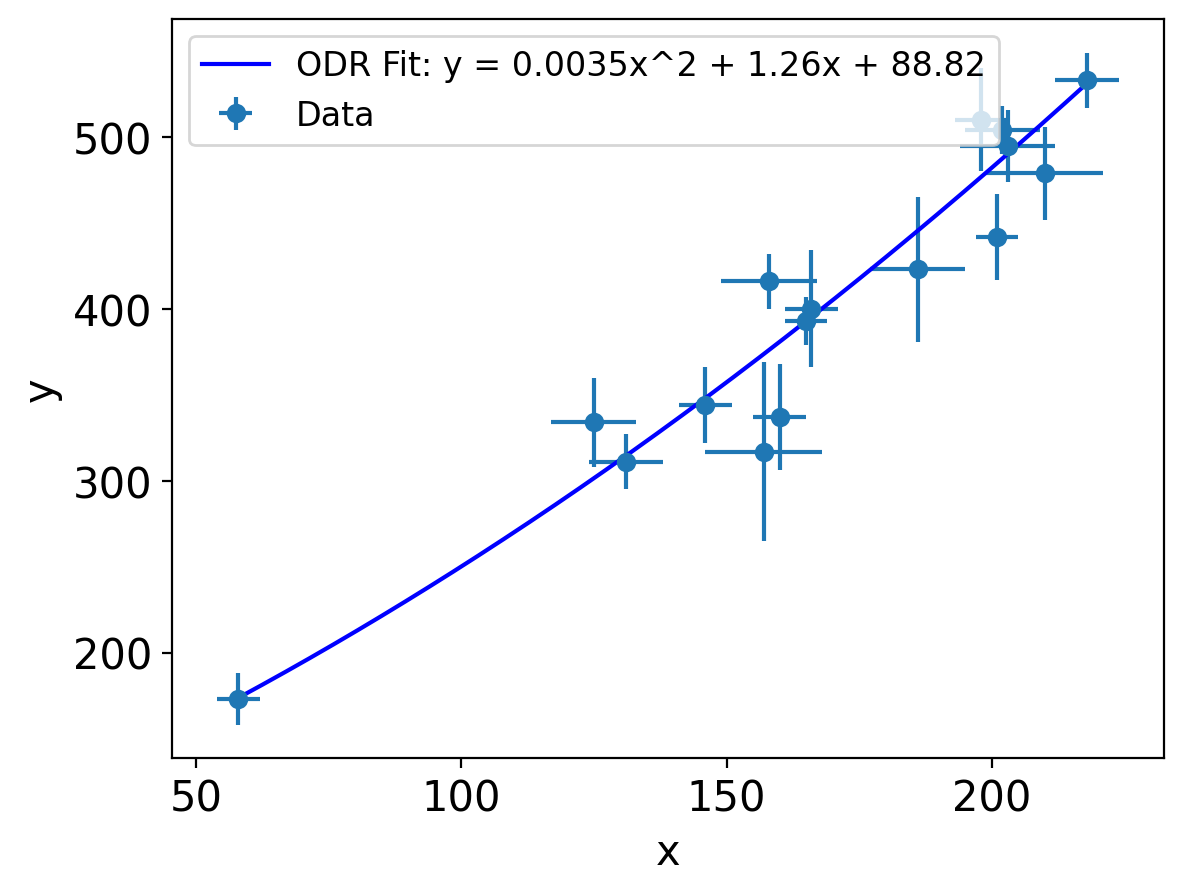

In [26]:
# scipy.odr 
from scipy.odr import ODR, Model, RealData

# Data (example data, replace with your actual data)
x_data = np.array([203, 58, 210, 202, 198, 158, 165, 201, 157, 131, 166, 160, 186, 125, 218, 146])
y_data = np.array([495, 173, 479, 504, 510, 416, 393, 442, 317, 311, 400, 337, 423, 334, 533, 344])
x_errors = np.array([9, 4, 11, 7, 5, 9, 4, 4, 11, 7, 5, 5, 9, 8, 6, 5])
y_errors = np.array([21, 15, 27, 14, 30, 16, 14, 25, 52, 16, 34, 31, 42, 26, 16, 22])

# Prepare the real data with uncertainties in both x and y
data = RealData(x_data, y_data, sx=x_errors, sy=y_errors)

# Define the quadratic model
def quadratic_model(parameters, x):
    q, m, b = parameters
    return q * x**2 + m * x + b

# Create a Model object based on the quadratic function
model = Model(quadratic_model)

# Set up ODR with the initial guess for the parameters (q, m, b)
odr = ODR(data, model, beta0=[0.001, 1, 100])

# Run the ODR fitting process
output = odr.run()

# Extract the fitted parameters
q_odr, m_odr, b_odr = output.beta
q_odr_err, m_odr_err, b_odr_err = output.sd_beta  # Standard deviations (uncertainties) of the parameters

# Print the results
print(f"ODR Fit: y = {q_odr:.4f}x^2 + {m_odr:.2f}x + {b_odr:.2f}")
print(f"Uncertainties: q_err = {q_odr_err:.4f}, m_err = {m_odr_err:.2f}, b_err = {b_odr_err:.2f}")

# Plot the result
x_smooth = np.linspace(min(x_data), max(x_data), 500)
y_fit = quadratic_model([q_odr, m_odr, b_odr], x_smooth)

# Plot data with error bars
plt.errorbar(x_data, y_data, xerr=x_errors, yerr=y_errors, fmt='o', label='Data')

# Plot the best fit quadratic curve
plt.plot(x_smooth, q_odr * x_smooth**2 + m_odr * x_smooth + b_odr, label=f'ODR Fit: y = {q_odr:.4f}x^2 + {m_odr:.2f}x + {b_odr:.2f}', color='blue')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


### Sneak Preview: Bayesian Fitting with a flat prior

You will discuss this in much more detail with Yuxiang in week 12.

But because it is soooooooo useful, I am already giving you a very basic example here.

This example is so simple, it is not even capitalizing the true power of Bayesian fitting: How you can fit better if you have additional information! This is usually done with a "prior".

In our example, we will simply assume that all coefficients that are numbers are valid.

Quadratic MCMC fit:
$q = 0.0025_{-0.0025}^{+0.0025}$
$m = 1.4992_{-0.6910}^{+0.7084}$
$b = 77.4930_{-46.0037}^{+43.7066}$


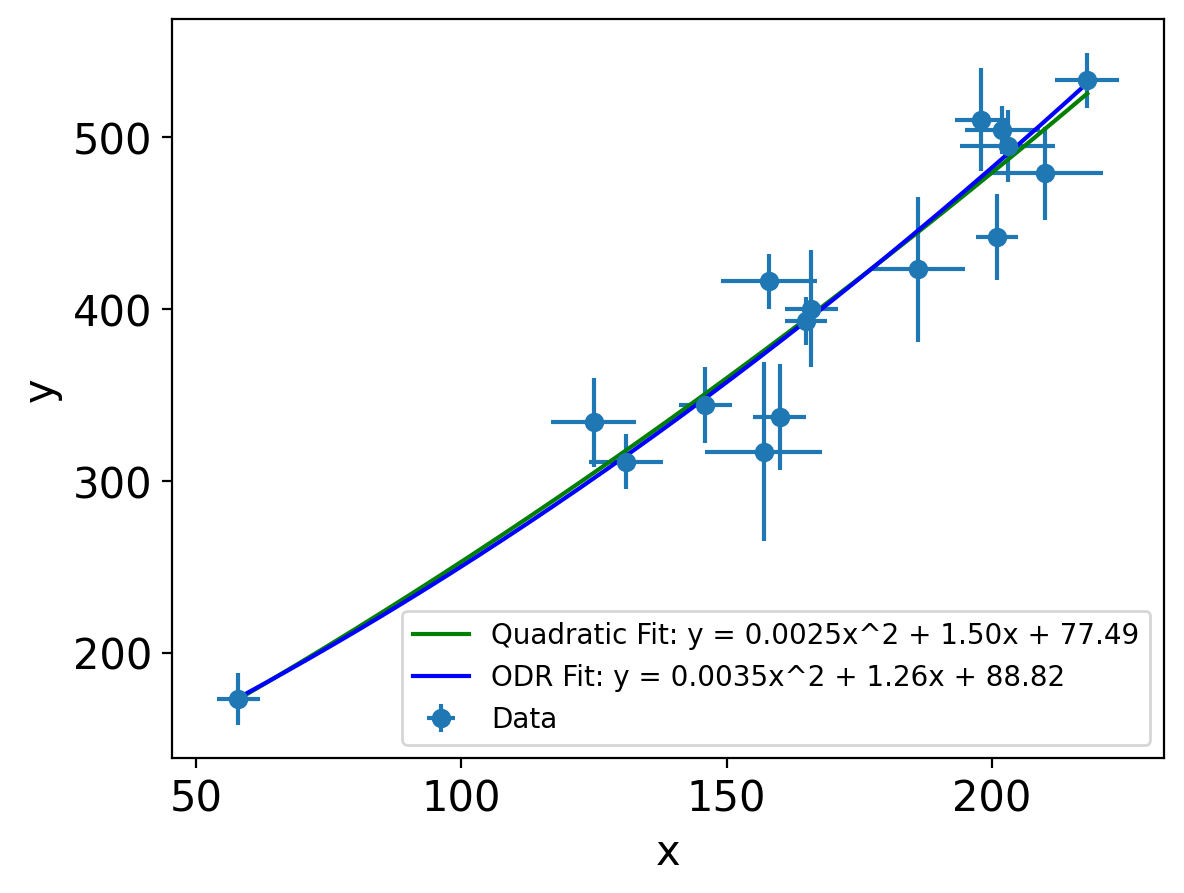

In [27]:
import emcee

# Data (example data, replace with your actual data)
x_data = np.array([203, 58, 210, 202, 198, 158, 165, 201, 157, 131, 166, 160, 186, 125, 218, 146])
y_data = np.array([495, 173, 479, 504, 510, 416, 393, 442, 317, 311, 400, 337, 423, 334, 533, 344])
x_errors = np.array([9, 4, 11, 7, 5, 9, 4, 4, 11, 7, 5, 5, 9, 8, 6, 5])
y_errors = np.array([21, 15, 27, 14, 30, 16, 14, 25, 52, 16, 34, 31, 42, 26, 16, 22])

# Quadratic model
def quadratic_model(params, x):
    q, m, b = params
    return q * x**2 + m * x + b

# Define the log-likelihood function that accounts for uncertainties in both x and y
def log_likelihood(parameters, x, y, xerr, yerr):
    q, m, b = parameters
    model = quadratic_model(parameters, x)
    sigma2 = yerr**2 + (2 * q * x + m)**2 * xerr**2  # Propagate x and y uncertainties
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

# Define the log-prior function. Here we simply say: our coefficients have to be numbers.
def log_prior(parameters):
    q, m, b = parameters
    if abs(q) >= 0 and abs(m) >= 0 and abs(b) >= 0:
        return 0.0
    return -np.inf

# Define the log-probability function
def log_probability(parameters, x, y, xerr, yerr):
    lp = log_prior(parameters)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(parameters, x, y, xerr, yerr)

# Initial guess for the parameters (q, m, b)
initial = np.array([1, 1, 1])

np.random.seed(13652344)

# Set up the MCMC sampler
nwalkers = 32
ndim = len(initial)
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)

# Set up and run the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x_data, y_data, x_errors, y_errors))
sampler.run_mcmc(pos, 5000)

# Get the samples from the posterior
samples = sampler.get_chain(discard=100, thin=10, flat=True)

# Get the best fit parameters by extracting the 16th, 50th, and 84th percentiles
q_mcmc_percentiles = np.percentile(samples[:, 0], [16, 50, 84])
m_mcmc_percentiles = np.percentile(samples[:, 1], [16, 50, 84])
b_mcmc_percentiles = np.percentile(samples[:, 2], [16, 50, 84])

# Define a function to print the percentiles in the desired LaTeX format
def print_percentiles_latex(parameter_name, percentiles):
    median = percentiles[1]
    lower_error = median - percentiles[0]
    upper_error = percentiles[2] - median
    print(f"${parameter_name} = {median:.4f}_{{-{lower_error:.4f}}}^{{+{upper_error:.4f}}}$")

# Print the percentiles for q, m, and b in LaTeX format
print("Quadratic MCMC fit:")
print_percentiles_latex("q", q_mcmc_percentiles)
print_percentiles_latex("m", m_mcmc_percentiles)
print_percentiles_latex("b", b_mcmc_percentiles)

# Plot the results
x_smooth = np.linspace(min(x_data), max(x_data), 500)

# Plot data with error bars
plt.errorbar(x_data, y_data, xerr=x_errors, yerr=y_errors, fmt='o', label='Data')

# Plot the best fit quadratic curve
plt.plot(x_smooth, quadratic_model([q_mcmc_percentiles[1], m_mcmc_percentiles[1], b_mcmc_percentiles[1]], x_smooth), label=f'Quadratic Fit: y = {q_mcmc_percentiles[1]:.4f}x^2 + {m_mcmc_percentiles[1]:.2f}x + {b_mcmc_percentiles[1]:.2f}', color='green')
plt.plot(x_smooth, q_odr * x_smooth**2 + m_odr * x_smooth + b_odr, label=f'ODR Fit: y = {q_odr:.4f}x^2 + {m_odr:.2f}x + {b_odr:.2f}', color='blue')

plt.xlabel('x')
plt.ylabel('y')
plt.legend(fontsize=10, loc='lower right')
plt.show()

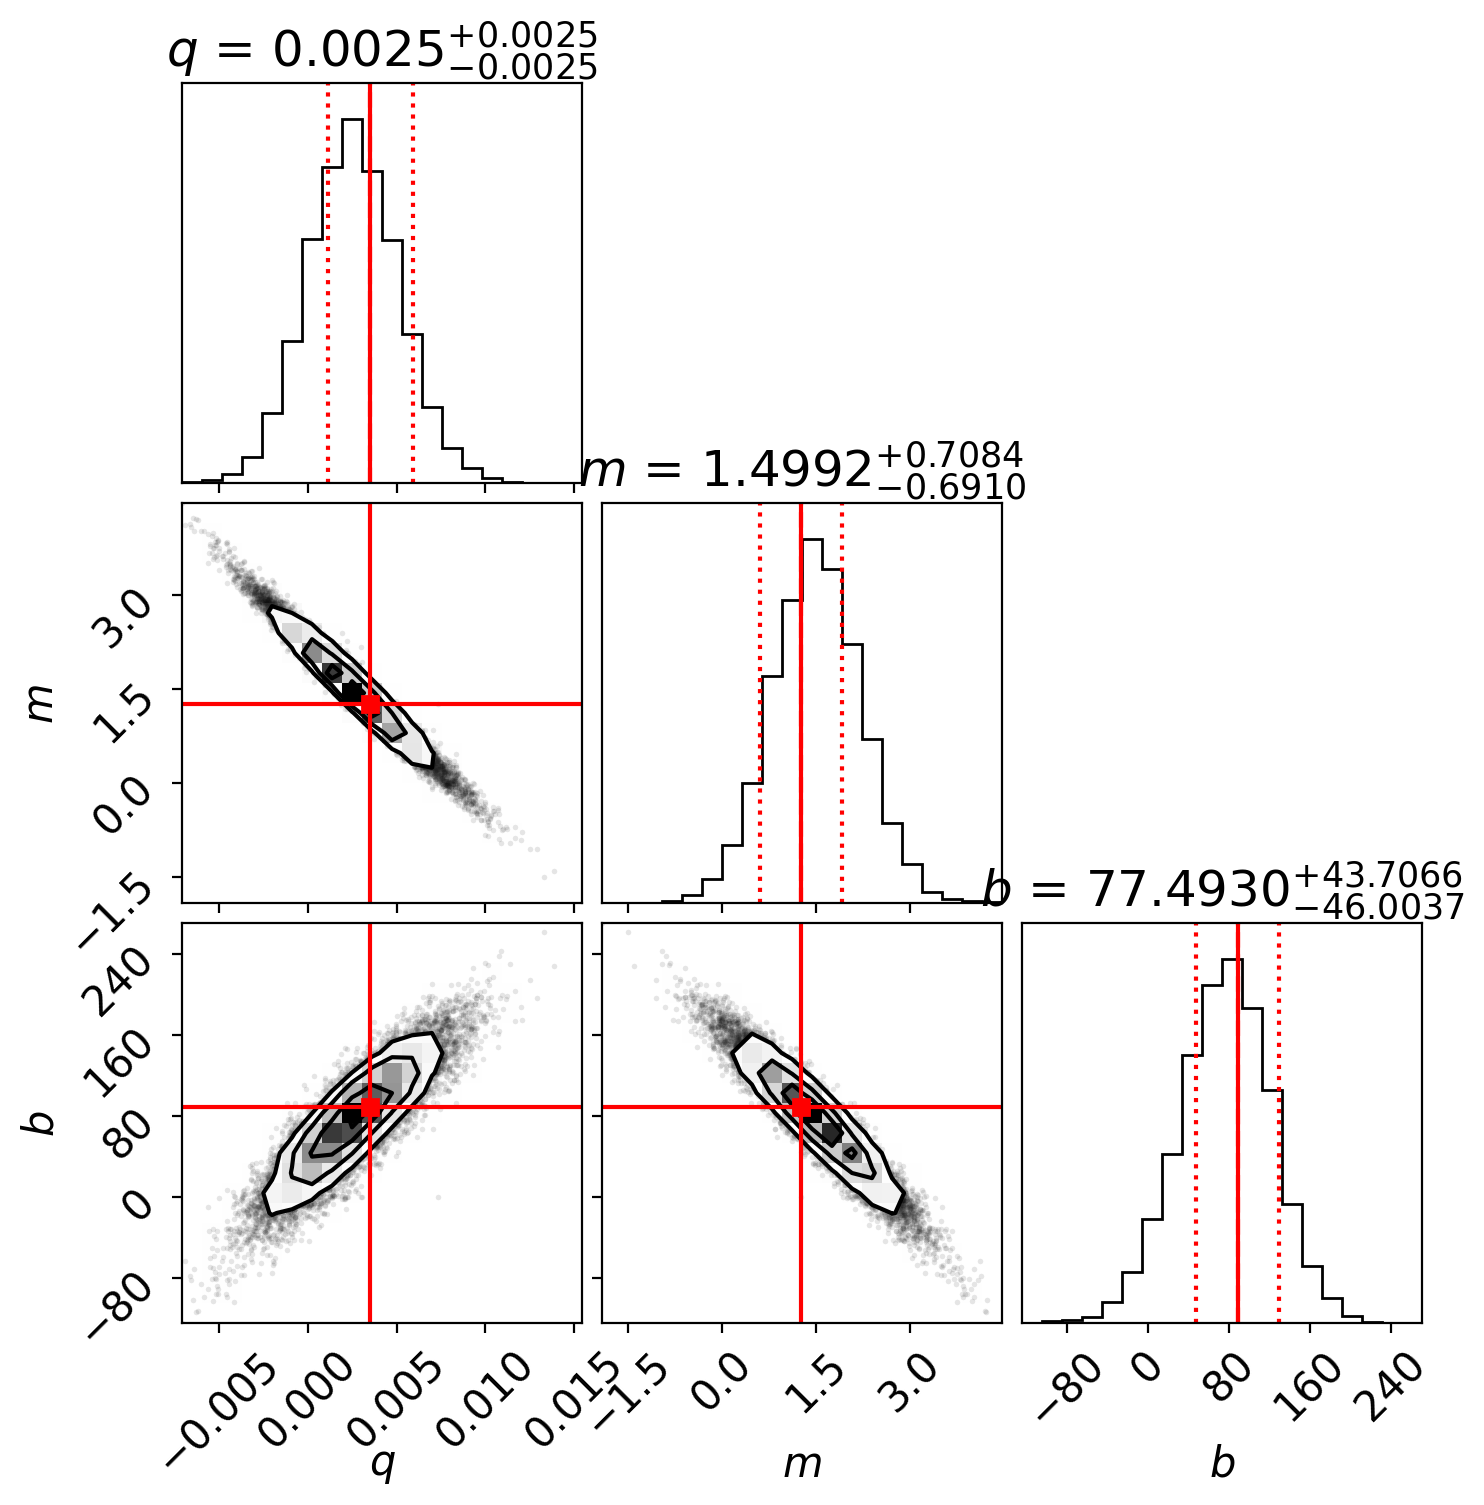

In [28]:
import corner

# Create the corner plot
fig = corner.corner(samples, labels=[r"$q$", r"$m$", r"$b$"], 
                    truths=[q_odr, m_odr, b_odr],
                    truth_color='red', show_titles=True, title_fmt=".4f")

# Extract the axes for adding ODR uncertainties
axes = np.array(fig.axes).reshape((3, 3))

# Overlay ODR best-fit values and uncertainties
for i, (value, err) in enumerate(zip([q_odr, m_odr, b_odr], [q_odr_err, m_odr_err, b_odr_err])):
    ax = axes[i, i]
    ax.axvline(value, color="red", linestyle="--")
    ax.axvline(value + err, color="red", linestyle=":")
    ax.axvline(value - err, color="red", linestyle=":")

plt.show()

## Jackknife and Bootstrap Resampling

In [29]:
import numpy as np
from scipy.optimize import curve_fit
from sklearn.utils import resample

# Example data from Exercise 2
x_data = np.array([203, 58, 210, 202, 198, 158, 165, 201, 157, 131, 166, 160, 186, 125, 218, 146])
y_data = np.array([495, 173, 479, 504, 510, 416, 393, 442, 317, 311, 400, 337, 423, 334, 533, 344])
y_errors = np.array([21, 15, 27, 14, 30, 16, 14, 25, 52, 16, 34, 31, 42, 26, 16, 22])

# Define the linear model
def linear_model(x, m, b):
    return m * x + b

# Step 1: Standard Fit
popt, pcov = curve_fit(linear_model, x_data, y_data, sigma=y_errors)
m_standard, b_standard = popt
sigma_m_standard = np.sqrt(pcov[0, 0])  # Uncertainty in slope m from the fit

print(f"Standard slope (m): {m_standard}")
print(f"Standard uncertainty in slope (sigma_m^2): {sigma_m_standard**2}")

# Step 2: Jackknife Resampling
n = len(x_data)
jackknife_slopes = []

for i in range(n):
    # Remove the i-th data point
    x_jackknife = np.delete(x_data, i)
    y_jackknife = np.delete(y_data, i)
    y_errors_jackknife = np.delete(y_errors, i)
    
    # Fit the model
    popt_jackknife, _ = curve_fit(linear_model, x_jackknife, y_jackknife, sigma=y_errors_jackknife)
    m_jackknife, _ = popt_jackknife
    jackknife_slopes.append(m_jackknife)

# Jackknife estimate of uncertainty
jackknife_slopes = np.array(jackknife_slopes)
m_jackknife_mean = np.mean(jackknife_slopes)
sigma_m_jackknife = np.sqrt((n - 1) * np.mean((jackknife_slopes - m_jackknife_mean) ** 2))

print(f"Jackknife uncertainty in slope (sigma_m^2): {sigma_m_jackknife**2}")

# Step 3: Bootstrap Resampling (20 trials)
n_trials = 20
bootstrap_slopes = []

for _ in range(n_trials):
    # Resample the data with replacement
    x_bootstrap, y_bootstrap, y_errors_bootstrap = resample(x_data, y_data, y_errors)
    
    # Fit the model
    popt_bootstrap, _ = curve_fit(linear_model, x_bootstrap, y_bootstrap, sigma=y_errors_bootstrap)
    m_bootstrap, _ = popt_bootstrap
    bootstrap_slopes.append(m_bootstrap)

# Bootstrap estimate of uncertainty
bootstrap_slopes = np.array(bootstrap_slopes)
sigma_m_bootstrap = np.std(bootstrap_slopes)

print(f"Bootstrap uncertainty in slope (sigma_m^2): {sigma_m_bootstrap**2}")

Standard slope (m): 2.239920815897764
Standard uncertainty in slope (sigma_m^2): 0.015500543778904929
Jackknife uncertainty in slope (sigma_m^2): 0.02771840216144414
Bootstrap uncertainty in slope (sigma_m^2): 0.012119399654192948


## A closer look at uncertainties in likelihood functions

In [30]:
def log_likelihood(params, x, y, sigma_x, sigma_y, rho_xy, model='linear'):
    """
    Optimized log-likelihood for a linear or quadratic model, 
    including uncertainties in both x and y, and correlations between x and y uncertainties.
    
    Parameters:
    - params: parameters of the model (e.g., [q, m, b] for quadratic, or [m, b] for linear)
    - x: array of independent variables (x-coordinates of data points)
    - y: array of dependent variables (y-coordinates of data points)
    - sigma_x: array of uncertainties in x
    - sigma_y: array of uncertainties in y
    - rho_xy: array of correlation coefficients between x and y uncertainties
    - model: 'linear' or 'quadratic' (default is 'linear')
    
    Returns:
    - log_likelihood: the log-likelihood value
    """
    # Vectorized model predictions and slopes
    if model == 'linear':
        m, b = params
        y_model = m * x + b
        slope = np.full_like(x, m)  # Constant slope for linear model
    
    elif model == 'quadratic':
        q, m, b = params
        y_model = q * x**2 + m * x + b
        slope = 2 * q * x + m  # Slope varies with x for quadratic model
    
    else:
        raise ValueError("Model type must be 'linear' or 'quadratic'")
    
    # Compute the residuals (differences between actual and predicted y-values)
    delta = y - y_model

    # Precompute terms for the covariance matrix projection
    v_perp_x = -(slope) / np.sqrt(slope**2 + 1)  # Perpendicular direction for x-component
    v_perp_y = 1 / np.sqrt(slope**2 + 1)  # Perpendicular direction for y-component
    
    # Covariance matrix diagonal and off-diagonal terms
    sigma_x2 = sigma_x**2
    sigma_y2 = sigma_y**2
    cov_xy = rho_xy * sigma_x * sigma_y  # Off-diagonal terms in the covariance matrix
    
    # Total uncertainty in the perpendicular direction (vectorized)
    sigma_perp2 = (v_perp_x**2 * sigma_x2 + v_perp_y**2 * sigma_y2 +
                   2 * v_perp_x * v_perp_y * cov_xy)

    # Compute the log-likelihood in a vectorized fashion
    log_likelihood = -0.5 * np.sum((delta**2 / sigma_perp2) + np.log(2 * np.pi * sigma_perp2))

    return log_likelihood

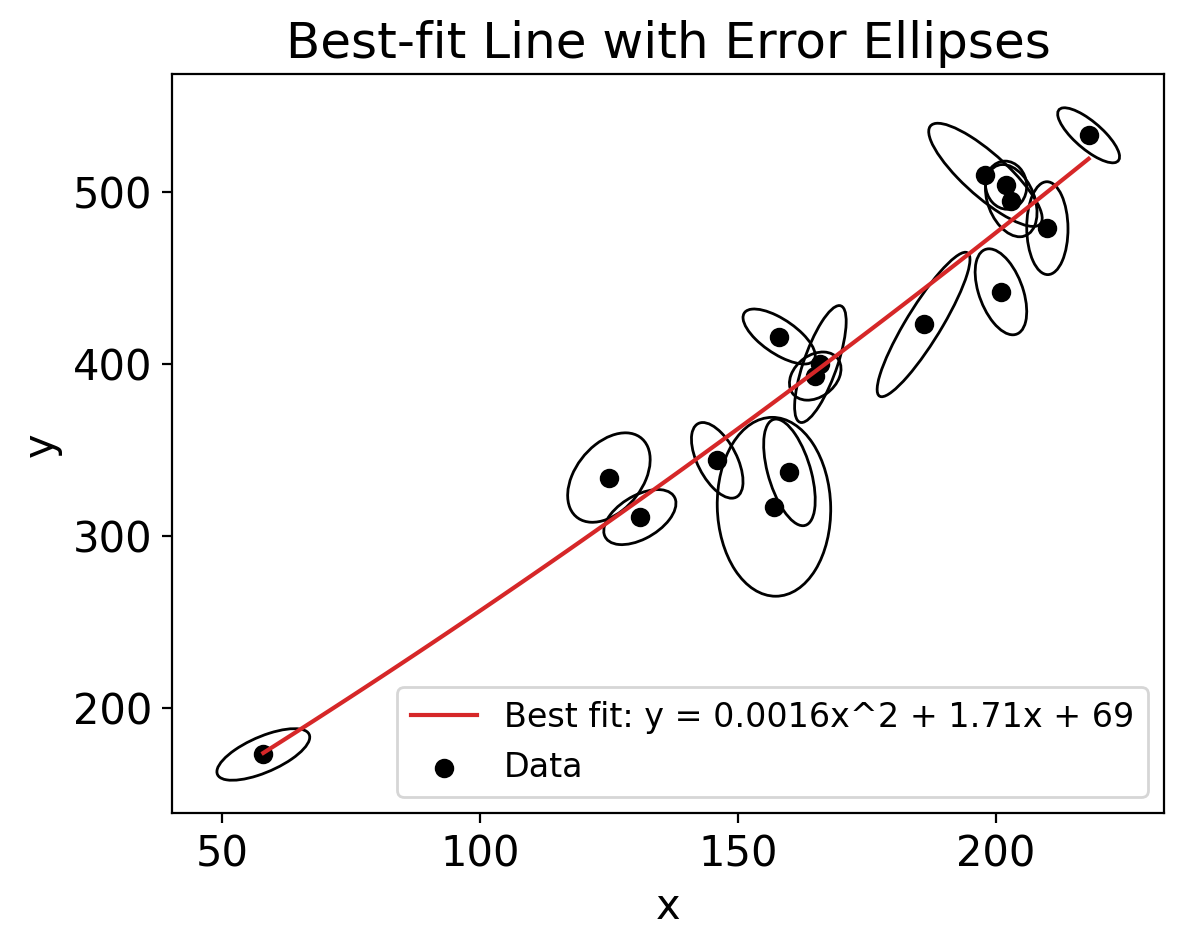

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Data for points 5 through 20 from Table 1
x_data = np.array([203, 58, 210, 202, 198, 158, 165, 201, 157, 131, 166, 160, 186, 125, 218, 146])
y_data = np.array([495, 173, 479, 504, 510, 416, 393, 442, 317, 311, 400, 337, 423, 334, 533, 344])
sigma_x = np.array([5, 9, 4, 4, 11, 7, 5, 5, 11, 7, 5, 5, 9, 8, 6, 5])
sigma_y = np.array([21, 15, 27, 14, 30, 16, 14, 25, 52, 16, 34, 31, 42, 26, 16, 22])
rho_xy = np.array([-0.33, 0.67, -0.02, -0.05, -0.84, -0.69, 0.30, -0.46, -0.03, 0.50, 0.73, -0.52, 0.90, 0.40, -0.78, -0.56])

# Covariance matrix assuming uncorrelated errors
def covariance_matrix(sigma_x, sigma_y, rho_xy):
    return np.array([[sigma_x**2, rho_xy * sigma_x * sigma_y],
                     [rho_xy * sigma_x * sigma_y, sigma_y**2]])

model = 'quadratic' # can be linear or quadratic

if model == 'linear':
    # Initial guess for slope (m) and intercept (b)
    initial_guess = [1, 100]
elif model == 'quadratic':
    # Initial guess for slope (m) and intercept (b)
    initial_guess = [1, 2, 70]
else:
    raise ValueError("Model type must be 'linear' or 'quadratic'")

def neg_log_likelihood(params, x, y, sigma_x, sigma_y, rho_xy, model=model):
    return -log_likelihood(params, x, y, sigma_x, sigma_y, rho_xy, model=model)

# Perform minimization to find the best-fit parameters
result = minimize(neg_log_likelihood, initial_guess, args=(x_data, y_data, sigma_x, sigma_y, rho_xy))

if model == 'linear':
    # Extract the best-fit slope and intercept
    best_m, best_b = result.x
    
    # Plot best-fit line
    x_fit = np.linspace(np.min(x_data), np.max(x_data))
    y_fit = best_m * x_fit + best_b

elif model == 'quadratic':
    # Extract the best-fit slope and intercept
    best_q, best_m, best_b = result.x
    
    # Plot best-fit line
    x_fit = np.linspace(np.min(x_data), np.max(x_data))
    y_fit = best_q * x_fit**2 + best_m * x_fit + best_b

# Plot the data with error ellipses
def plot_error_ellipses(x_data, y_data, sigma_x, sigma_y, rho_xy):
    fig, ax = plt.subplots()
    
    # Plot data points with ellipses
    for i in range(len(x_data)):
        cov = covariance_matrix(sigma_x[i], sigma_y[i], rho_xy[i])
        lambda_, v = np.linalg.eig(cov)  # Eigenvalues and eigenvectors
        lambda_ = np.sqrt(lambda_)  # Square roots of eigenvalues give axis lengths
        
        # Compute the angle of the ellipse (from the eigenvector corresponding to the largest eigenvalue)
        angle = np.arctan2(v[1, 0], v[0, 0]) * 180.0 / np.pi
        
        ell = plt.matplotlib.patches.Ellipse(xy=(x_data[i], y_data[i]),
                                             width=lambda_[0]*2, height=lambda_[1]*2,
                                             angle=angle, edgecolor='k', facecolor='none')
        ax.add_patch(ell)
    
    if model == 'linear':
        ax.plot(x_fit, y_fit, color='C3', label=f'Best fit: y = {best_m:.2f}x + {best_b:.2f}')
    elif model == 'quadratic':
        ax.plot(x_fit, y_fit, color='C3', label=f'Best fit: y = {best_q:.4f}x^2 + {best_m:.2f}x + {best_b:.0f}')
        
    # Scatter plot of data points
    ax.scatter(x_data, y_data, color='k', label='Data')
    
    # Labels and legend
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    plt.title('Best-fit Line with Error Ellipses')
    plt.show()

# Plot the data with error ellipses and best-fit line
plot_error_ellipses(x_data, y_data, sigma_x, sigma_y, rho_xy)


100%|██████████| 500/500 [00:05<00:00, 87.20it/s]


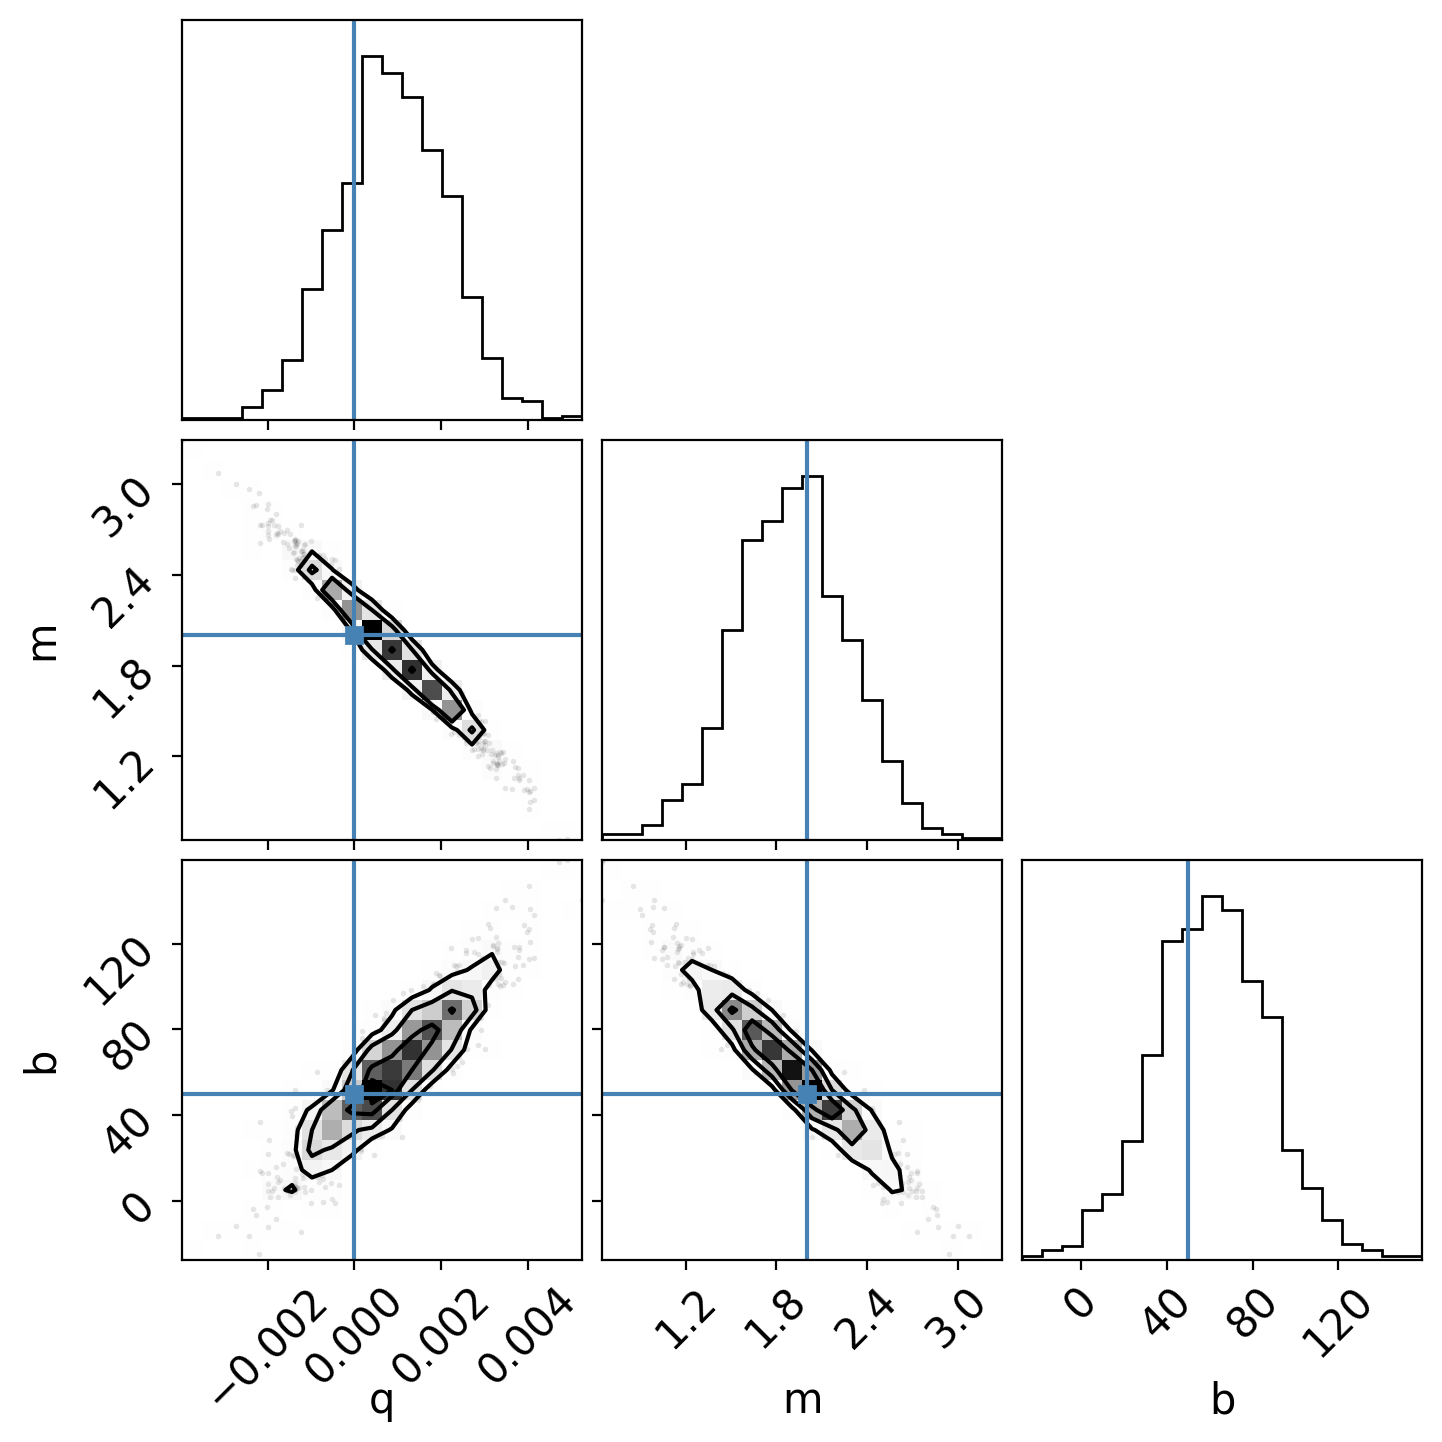

Best-fit quadratic coefficient (q) from MCMC: 0.0008810730608755109
Best-fit slope (m) from MCMC: 1.911744907122121
Best-fit intercept (b) from MCMC: 61.20342298019756


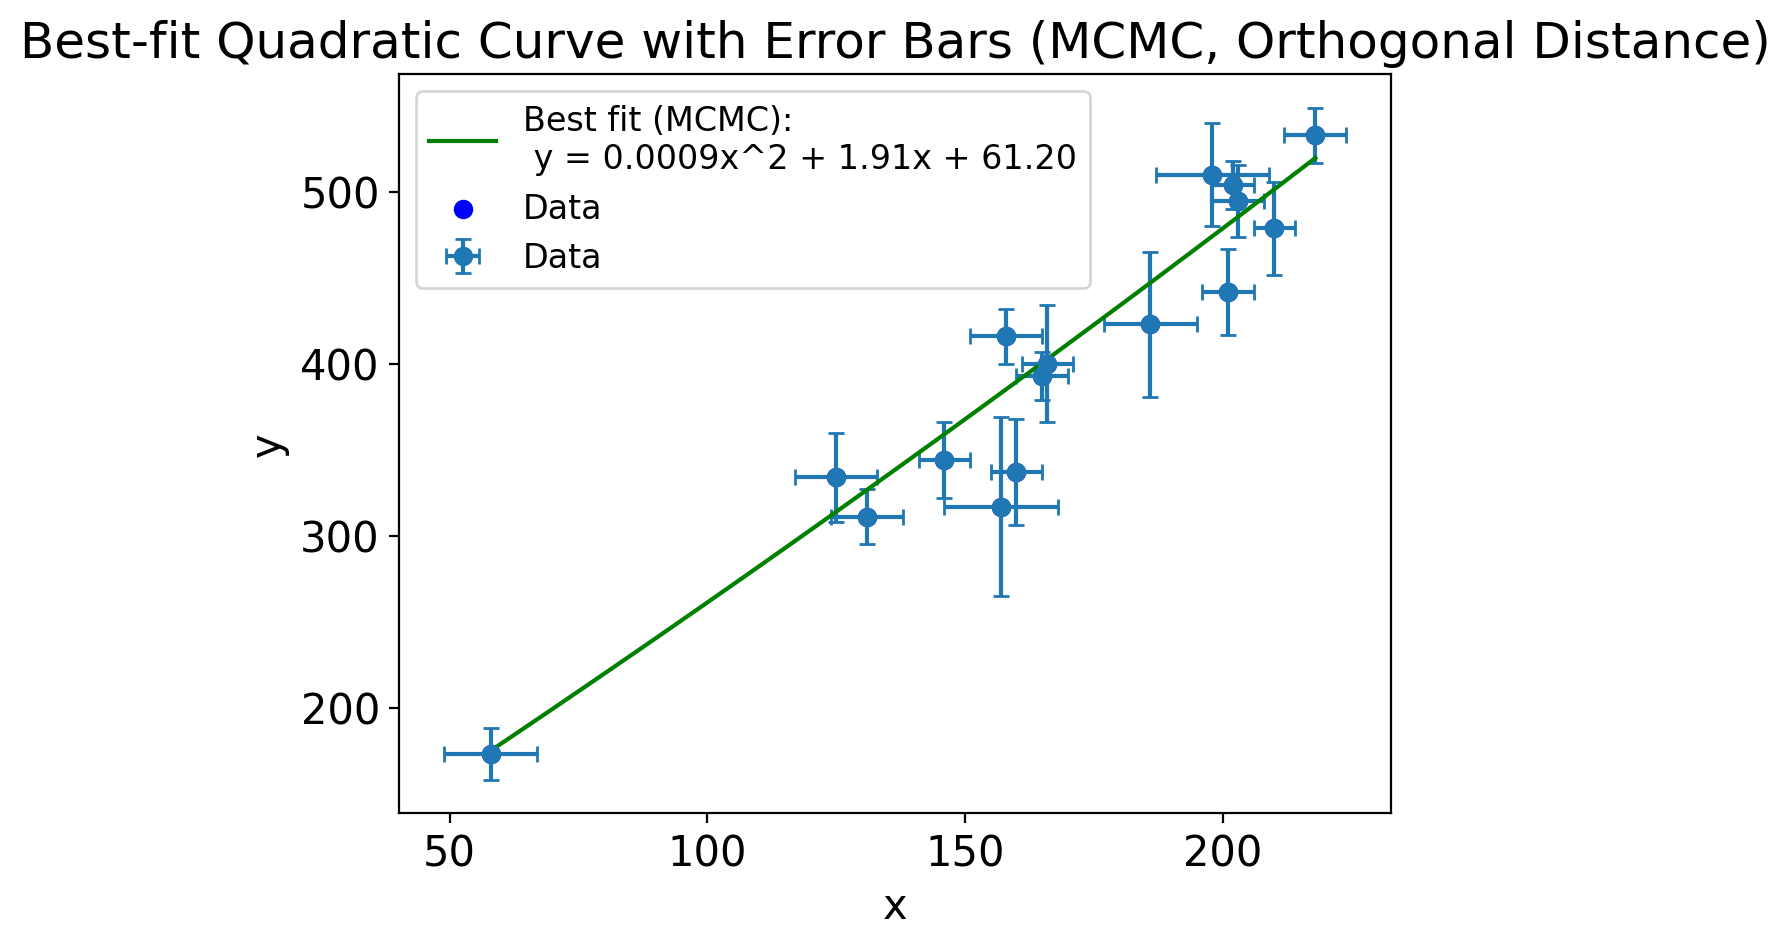

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import emcee

# Data from Table 1 (points 5 to 20)
x_data = np.array([203, 58, 210, 202, 198, 158, 165, 201, 157, 131, 166, 160, 186, 125, 218, 146])
y_data = np.array([495, 173, 479, 504, 510, 416, 393, 442, 317, 311, 400, 337, 423, 334, 533, 344])
sigma_x = np.array([5, 9, 4, 4, 11, 7, 5, 5, 11, 7, 5, 5, 9, 8, 6, 5])
sigma_y = np.array([21, 15, 27, 14, 30, 16, 14, 25, 52, 16, 34, 31, 42, 26, 16, 22])

# Covariance matrix assuming uncorrelated errors
def covariance_matrix(sigma_x, sigma_y):
    return np.array([[sigma_x**2, 0],
                     [0, sigma_y**2]])

# Quadratic model
def quadratic_model(x, q, m, b):
    return q * x**2 + m * x + b

# Orthogonal distance calculation for a quadratic function
def orthogonal_distance_quadratic(params, x, y, sigma_x, sigma_y):
    q, m, b = params
    y_model = quadratic_model(x, q, m, b)  # Compute the y value from the quadratic model
    delta = y - y_model  # Distance between the data point and the curve
    S = covariance_matrix(sigma_x, sigma_y)  # Covariance matrix (uncorrelated errors)
    # Calculate perpendicular distance (same unit vector approach)
    v_perp = np.array([2 * q * x + m, -1]) / np.sqrt((2 * q * x + m)**2 + 1)  # Unit vector orthogonal to the curve
    sigma_perp = np.dot(np.dot(v_perp.T, S), v_perp)  # Projected uncertainty
    return delta**2 / sigma_perp  # Normalized distance

# Log-likelihood function for MCMC (based on orthogonal distance)
def log_likelihood(params, x, y, sigma_x, sigma_y):
    residuals = [orthogonal_distance_quadratic(params, x[i], y[i], sigma_x[i], sigma_y[i]) for i in range(len(x))]
    return -0.5 * np.sum(residuals)

# Define the log-prior function (uniform priors)
def log_prior(params):
    q, m, b = params
    if abs(q) >= 0 and abs(m) >= 0 and abs(b) >= 0:  # Priors on q, m, and b
        return 0.0
    return -np.inf  # Return -inf outside the bounds

# Define the log-posterior function (log-prior + log-likelihood)
def log_posterior(params, x, y, sigma_x, sigma_y):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y, sigma_x, sigma_y)

# Initial guess for q, m, and b
initial_guess = [0.00, 2., 50]

# Set up the MCMC sampler
ndim = 3  # Number of parameters (q, m, b)
nwalkers = 50  # Number of MCMC walkers
nsteps = 500  # Number of MCMC steps per walker
pos = initial_guess + 1e-4 * np.random.randn(nwalkers, ndim)  # Initial positions of walkers

# Set up the MCMC sampler using emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x_data, y_data, sigma_x, sigma_y))

# Run the MCMC sampler
sampler.run_mcmc(pos, nsteps, progress=True)

# Extract the samples
samples = sampler.get_chain(discard=100, thin=15, flat=True)

# Plot the MCMC chains
import corner

# Corner plot to visualize the posterior distributions
fig = corner.corner(samples, labels=["q", "m", "b"], truths=initial_guess)
plt.show()

# Extract the best-fit parameters (median of posterior)
q_mcmc, m_mcmc, b_mcmc = np.median(samples, axis=0)
print(f"Best-fit quadratic coefficient (q) from MCMC: {q_mcmc}")
print(f"Best-fit slope (m) from MCMC: {m_mcmc}")
print(f"Best-fit intercept (b) from MCMC: {b_mcmc}")

# Plot the data with error bars and the MCMC best-fit line
def plot_mcmc_fit(x_data, y_data, sigma_x, sigma_y, q_best, m_best, b_best):
    fig, ax = plt.subplots()
    
    # Plot error bars
    ax.errorbar(x_data, y_data, xerr=sigma_x, yerr=sigma_y, fmt='o', label='Data', capsize=3)

    # Plot best-fit quadratic curve
    x_fit = np.linspace(min(x_data), max(x_data), 100)
    y_fit = quadratic_model(x_fit, q_best, m_best, b_best)
    ax.plot(x_fit, y_fit, color='green', label=f'Best fit (MCMC):\n y = {q_best:.4f}x^2 + {m_best:.2f}x + {b_best:.2f}')
    
    # Scatter plot of data points
    ax.scatter(x_data, y_data, color='blue', label='Data')
    
    # Labels and legend
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    plt.title('Best-fit Quadratic Curve with Error Bars (MCMC, Orthogonal Distance)')
    plt.show()

# Plot the MCMC fit
plot_mcmc_fit(x_data, y_data, sigma_x, sigma_y, q_mcmc, m_mcmc, b_mcmc)
